## Table of Contents

* [Library Import](#Library_Import)
* [Data Import](#data_import)
    * [Biological Replicate 1](#Biological_Replicate_1)
    * [Biological Replicate 2](#Biological_Replicate_2)  
    * [Biological Repliate 3](#Biological_Replicate_3)       
* [Inter-Run-Calibrators (IRC)](#IRC)
* [Merged Data](#Merge)
    * [Set Clone, treatment, and zeitgeber](#sample_ids)
        * [Reference Genes](#ref_genes) 
            * [MSI1](#treat_m)
                * [Plot](#plot_m)
                * [Stats](#stats_m)
            * [GAPDH](#treat_G)
                * [Plot](plot_g)
                * [Stats](plot_g)
            * [Comments](#ref_comments)
        * [Target Genes](#target_genes)
            * [LHY](#LHY)
            * [PRR9](#PRR9)
            * [LUX](#LUX)
            * [PRDX](#PRDX)
            * [PRR7](#PRR7)
            * [PRR5](#PRR5)
            * [LUX](#LUX)
            * [TOC1](#TOC1)
            * [Statistics](#all_stats)

### Library Import <a class="anchor" id="Library_Import"></a>

In [ ]:
# Import libraries

import pandas as pd
from pathlib import Path
import numpy as np
import os
from math import isnan
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Import plot libraries

import matplotlib as mpl
import matplotlib.pyplot as pp
import seaborn as sb

# Set custom design for plots

%matplotlib inline
IPython_default = pp.rcParams.copy()
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#66EEEE', '#690202',
                 '#022869', '#9988DD', '#88BB44'])
# color order: bright red, bright blue, dark red, dark blue, purple, green
mpl.rcParams['font.family'] = 'helvetica'
params = {'legend.fontsize': 20,
          'figure.figsize': (16, 8),
         'axes.labelsize': 24,
         'axes.titlesize': 40,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
mpl.rcParams.update(params)
pp.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
pp.rc('grid', color='w', linestyle='solid')
pp.rc('xtick', direction='out', color='black')
pp.rc('ytick', direction='out', color='black')
pp.rc('patch', edgecolor='#E6E6E6')
pp.rc('lines', linewidth=2)

# Statistics
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp


## Data Import <a class="anchor" id="data_import"></a>

## Biological Replicate 1 <a class="anchor" id="Biological_Replicate_1"></a>

In [3]:
LHY_1 = pd.read_csv(Path("plate1_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_1 = pd.read_csv(Path("plate2_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_1 = pd.read_csv(Path("plate4_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_1 = pd.read_csv(Path("plate5_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_1 = pd.read_csv(Path("plate6_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1) 
LUX_1 = pd.read_csv(Path("plate19_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
PRR7_1 = pd.read_csv(Path("plate21_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
PRR5_1 = pd.read_csv(Path("plate24_Cq_Results.csv"), decimal = ",", index_col=1)
RVE8_1 = pd.read_csv(Path("plate27_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)
TOC1_1 = pd.read_csv(Path("plate30_Cq_Results.csv"), delimiter=";", decimal=",",index_col=1)

In [5]:
genes_br_1 = [LHY_1, GAPDH_1, PRR9_1, PRDX_1, MSI1_1, LUX_1, PRR7_1, PRR5_1, RVE8_1, TOC1_1]
br_1 = pd.concat(genes_br_1)

## Cleanup

* Drop all unneccessary columns
* Replace Sample "NaN" with "NTC"
* Replace Cq "NaN" with 0
* Replace "GADPH" with "GAPDH" (typo)
* Change Target "IRC" from "GAPDH" to "IRC" for IRC samples
* Drop all Cq's of 0 (NTC's and if any wells failed. ex: GAPDH I1 13C.) 
* Create high samples dataframe to identify samples to remove (Cq >30)

In [9]:
br_1.reset_index(inplace = True)
br_1.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

In [12]:
br_1["Sample"] = br_1["Sample"].replace(np.nan, "NTC")
br_1["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)
br_1["Cq"] = br_1["Cq"].replace(np.nan, 0)

br_1.loc[br_1["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_1.loc[br_1["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_1.loc[br_1["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"

br_1 = br_1[br_1.Cq != 0]

In [ ]:
High_samples_1 = br_1.loc[br_1["Cq"]>30]
High_samples_1['Sample'] = High_samples_1['Sample'].astype(str) + '_1'

High_samples_1 = High_samples_1.pivot_table(columns = "Target",
                                           index = "Sample",
                                           values = ["Cq"])

High_samples_1.to_csv('High_samples_1.csv', index = True)

In [16]:
br_1.loc[br_1["Cq"]<19, :]

,index,Target,Sample,Cq
38,38,LHY,NTC,0.000000
77,77,LHY,NTC,0.000000
85,85,GAPDH,N2_3A,18.114577
95,95,GAPDH,N2_8A,18.432379
119,119,GAPDH,NTC,0.000000
156,156,GAPDH,I1_13C,0.000000
158,158,GAPDH,NTC,0.000000
200,200,PRR9,NTC,0.000000
239,239,PRR9,NTC,0.000000
241,241,IRC2,IRC2_4,0.000000


In [18]:
br_1.loc[br_1["Sample"] == "IRC1_4"]

,index,Target,Sample,Cq
240,240,IRC1,IRC1_4,37.370395


For plate 4 I forgot to do IRC samples. IRC1_4 has Cq 37 with no template, other wells have no Cq, indicatin possibility of primer-dimer. Melt curves for plate 4 confirm this. 

In [19]:
br_1.drop([240], axis = 0, inplace = True)
br_1.reset_index(inplace = True, drop = True)

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
def define_column_by(df, old_col, new_col, x, out): 
    
    """ Creates new description column based on another columns description. 
    
    Can split sample names into new columns so those columns can be used as identifiers.     
    :param df: Pandas DataFrame
    :param old_col: old column to use as identifier. Must be a string.
    :param new_col: new column where to add the new identifying phrase. Must be a string.
    :param x: phrase in the old column to use as identifier. Must be a string.
    :param out: new phrase to print in new column. Must be a string.
    
    :return: The updated dataframe
    :rtype: Pandas Dataframe
    """
    
    df[new_col] = np.where(df[old_col].str.contains(x), out, df[new_col])
    return(df)

In [21]:
br_1.loc[(br_1["Sample"] == "N2_5A") | 
         (br_1["Sample"] == "I1_8A") |
         (br_1["Sample"] == "I1_11B") |
         (br_1["Sample"] == "I1_13C")| 
         (br_1["Sample"] == "I1_13D")]

,index,Target,Sample,Cq
8,8,LHY,N2_5A,32.630286
52,53,LHY,I1_8A,33.183911
65,66,LHY,I1_11B,31.180700
74,75,LHY,I1_13C,36.819253
75,76,LHY,I1_13D,26.676258
87,89,GAPDH,N2_5A,28.186665
131,134,GAPDH,I1_8A,28.984997
144,147,GAPDH,I1_11B,25.504285
153,157,GAPDH,I1_13D,24.549251
165,170,PRR9,N2_5A,31.193318


#### Drop bad samples

In [22]:
# "N2_5A", "I1_8A", "I1_11B", "I1_13C", "I1_13D"

define_column_by(br_1, "Sample", "Cq", "N2_5A", 0)   
define_column_by(br_1, "Sample", "Cq", "I1_8A", 0) 
define_column_by(br_1, "Sample", "Cq", "I1_11B", 0)
define_column_by(br_1, "Sample", "Cq", "I1_13C", 0) 
define_column_by(br_1, "Sample", "Cq", "I1_13D", 0) 

br_1.Cq = pd.to_numeric(br_1.Cq, errors = 'coerce')

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Pivot Table

Create pivot table for gene names, remove IRC columns from pivot

In [23]:
br_1_pivot = br_1.pivot_table(columns = "Target", 
                              index = "Sample", 
                              values = ["Cq"]).replace(0, np.NaN)

br_1_pivot.reset_index(inplace = True)
br_1_pivot.drop(columns=[('Cq', 'IRC1'), ('Cq', 'IRC2'), ('Cq', 'IRC3')], axis = 1, inplace = True)

In [24]:
br_1_pivot

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  21.278777  24.282946  27.943621  26.854128  22.831522   
1       I1_10B  23.274071  29.882935  28.276974  28.639061  24.384004   
2       I1_10C  24.537939  24.631841  32.524723  29.016232  24.974279   
3       I1_10D  22.188337  25.568140  28.351891  27.126171  25.856593   
4       I1_11A  24.549344  30.533012  30.017440  29.878743  26.652670   
..         ...        ...        ...        ...        ...        ...   
98       N2_8D  20.396178  19.623235  32.380591  26.579508  22.213171   
99       N2_9A  21.336921  22.277157  28.597434  26.886064  23.356187   
100      N2_9B  20.724947  25.105930  27.297274  25.994662  22.355597   
101      N2_9C  21.899637  22.213453  30.457152  28.155588  25.366425   
102      N2_9D  22.729776  22.430877  28.735701  27.091975  23.862668   

                                                               
Target       PRR5       PRR7       PRR9       RVE8       TOC1  
0       24.898295  24.742284  24.430283  27.257026  27.055095  
1       26.319178  25.303377  26.606915  32.379393  28.374669  
2       28.283442  27.143070  27.995060  27.540051  30.649828  
3       26.022630  26.712508  29.269084  34.020824  31.104646  
4       28.284798  26.951901  29.470427  32.063919  29.306058  
..            ...        ...        ...        ...        ...  
98      30.230407  28.774953  30.223121  24.309265  28.221951  
99      26.004822  25.637391  24.184715  26.811380  27.603507  
100     24.612746  24.834116  22.199799  28.366751  27.245141  
101     28.401850  27.003441  28.833112  25.396947  28.003486  
102     25.594706  26.286040  26.695584  27.238251  27.803615  

[103 rows x 11 columns]

IRC samples are still in sample column, drop all IRC samples from pivot

In [25]:
IRC1_list =[] 
  
for index, rows in br_1_pivot.iterrows(): 
    
     if "IRC" in rows[('Sample', '')]:
            my_list = rows[('Sample', '')]
            
            IRC1_list.append(my_list)

In [26]:
br_1_pivot = br_1_pivot[~br_1_pivot['Sample'].isin(IRC1_list)]

#### ΔCq 

In [27]:
# deltaCq = CQ (GOI) - CQ (MSI1)
br_1_pivot[('deltaCq', 'LHY')] = br_1_pivot[(    'Cq',   'LHY')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'LUX')] = br_1_pivot[(    'Cq',   'LUX')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'PRDX')] = br_1_pivot[(    'Cq',  'PRDX')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'PRR9')] = br_1_pivot[(    'Cq',  'PRR9')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'PRR7')] = br_1_pivot[(    'Cq',  'PRR7')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'PRR5')] = br_1_pivot[(    'Cq',  'PRR5')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'RVE8')] = br_1_pivot[(    'Cq',  'RVE8')].sub(br_1_pivot[(    'Cq', 'MSI1')])
br_1_pivot[('deltaCq', 'TOC1')] = br_1_pivot[(    'Cq',  'TOC1')].sub(br_1_pivot[(    'Cq', 'MSI1')])


/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

### 2<sup>-ΔCq

In [28]:
br_1_pivot[('2-deltaCq', 'LHY')] = br_1_pivot[('deltaCq', 'LHY')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'PRDX')] = br_1_pivot[('deltaCq', 'PRDX')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'PRR9')] = br_1_pivot[('deltaCq', 'PRR9')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'LUX')] = br_1_pivot[('deltaCq', 'LUX')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'PRR7')] = br_1_pivot[('deltaCq', 'PRR7')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'PRR5')] = br_1_pivot[('deltaCq', 'PRR5')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'RVE8')] = br_1_pivot[('deltaCq', 'RVE8')].apply(lambda x: 2 ** -(x))
br_1_pivot[('2-deltaCq', 'TOC1')] = br_1_pivot[('deltaCq', 'TOC1')].apply(lambda x: 2 ** -(x))

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [29]:
br_1_pivot.head()

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  21.278777  24.282946  27.943621  26.854128  22.831522   
1       I1_10B  23.274071  29.882935  28.276974  28.639061  24.384004   
2       I1_10C  24.537939  24.631841  32.524723  29.016232  24.974279   
3       I1_10D  22.188337  25.568140  28.351891  27.126171  25.856593   
4       I1_11A  24.549344  30.533012  30.017440  29.878743  26.652670   

                                                    ...   deltaCq            \
Target       PRR5       PRR7       PRR9       RVE8  ...      RVE8      TOC1   
0       24.898295  24.742284  24.430283  27.257026  ...  0.402898  0.200967   
1       26.319178  25.303377  26.606915  32.379393  ...  3.740333 -0.264392   
2       28.283442  27.143070  27.995060  27.540051  ... -1.476181  1.633595   
3       26.022630  26.712508  29.269084  34.020824  ...  6.894653  3.978475   
4       28.284798  26.951901  29.470427  32.063919  ...  2.185176 -0.572685   

        2-deltaCq                                                      \
Target        LHY       PRDX      PRR9       LUX       PRR7      PRR5   
0        5.942962  16.252683  5.365993  0.469927   4.322433  3.879398   
1        0.422237  19.094122  4.090126  1.285284  10.095799  4.992917   
2       20.884935  16.472109  2.029567  0.087870   3.663347  1.661850   
3        2.944517   2.410911  0.226422  0.427584   1.332063  2.148814   
4        0.635398   9.357176  1.327136  0.908339   7.604443  3.018737   

                            
Target      RVE8      TOC1  
0       0.756338  0.869967  
1       0.074825  1.201130  
2       2.782114  0.322284  
3       0.008404  0.063439  
4       0.219885  1.487289  

[5 rows x 27 columns]

In [30]:
br1_stats = br_1_pivot.set_index("Sample").swaplevel(0,1,axis =1).stack(level=0)
br1_stats.head()

2-deltaCq         Cq   deltaCq
Sample Target                                
I1_10A GAPDH         NaN  21.278777       NaN
       LHY      5.942962  24.282946 -2.571182
       LUX      0.469927  27.943621  1.089493
       MSI1          NaN  26.854128       NaN
       PRDX    16.252683  22.831522 -4.022606

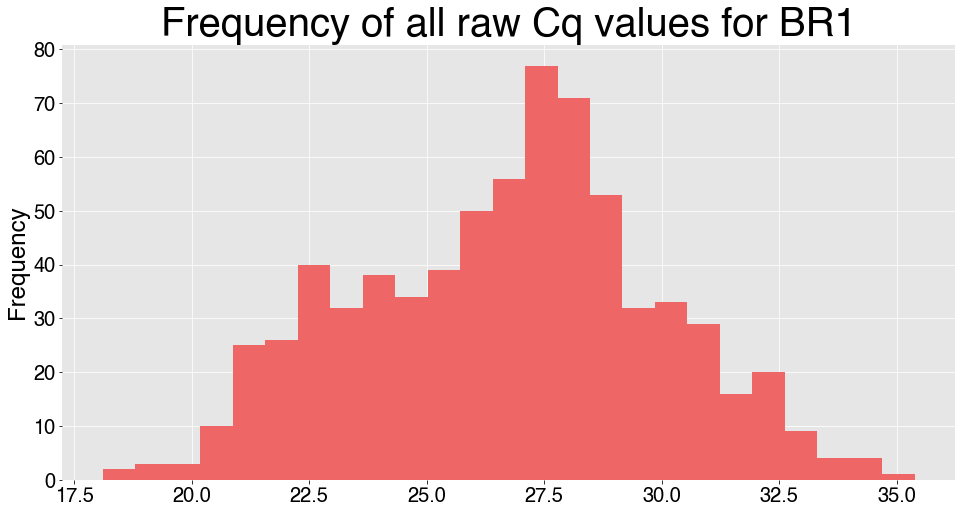

In [31]:
br1_stats["Cq"].plot(kind="hist", bins = 25)
pp.title("Frequency of all raw Cq values for BR1")
pp.show()

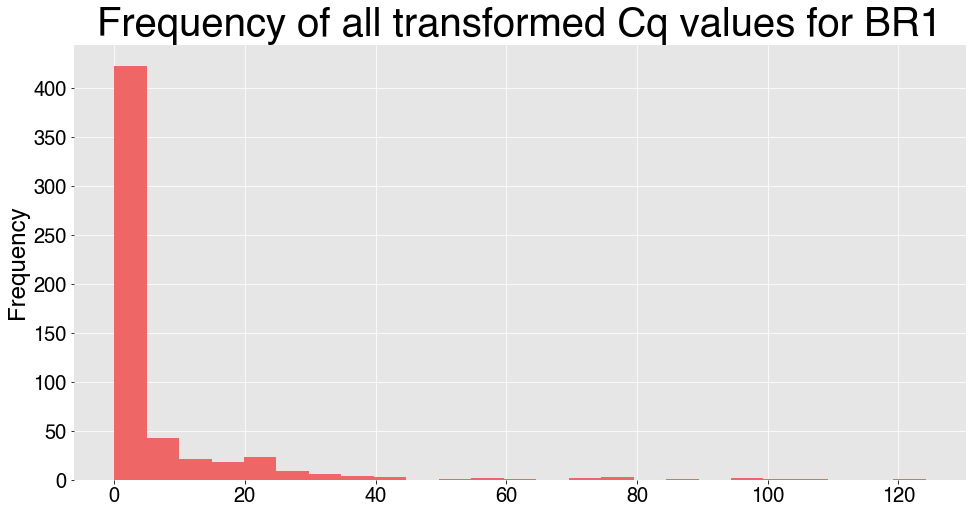

In [32]:
br1_stats["2-deltaCq"].plot(kind = "hist", bins = 25)
pp.title("Frequency of all transformed Cq values for BR1")
pp.show()

In [33]:
br1_stats.loc[br1_stats["2-deltaCq"]>60]

,,2-deltaCq,Cq,deltaCq
Sample,Target,,,
I1_13B,LHY,94.674147,23.124704,-6.564899
I1_1B,LHY,94.828634,22.353653,-6.567251
I1_2B,LHY,74.666057,21.356993,-6.222381
I1_7B,LHY,75.072717,23.399793,-6.230217
I1_8B,LHY,100.809202,20.910561,-6.655484
I1_8C,LHY,85.136282,20.750477,-6.411702
I1_9B,PRDX,74.888204,21.512590,-6.226667
I1_9C,LHY,74.500505,20.394064,-6.219178
N2_13B,LHY,70.019159,19.797950,-6.129678


In [34]:
br1_stats.loc[br1_stats["2-deltaCq"]<0.5]

2-deltaCq         Cq   deltaCq
Sample Target                                
I1_10A LUX      0.469927  27.943621  1.089493
I1_10B LHY      0.422237  29.882935  1.243874
       RVE8     0.074825  32.379393  3.740333
I1_10C LUX      0.087870  32.524723  3.508491
       TOC1     0.322284  30.649828  1.633595
...                  ...        ...       ...
N2_9B  LUX      0.405391  27.297274  1.302613
       RVE8     0.193166  28.366751  2.372089
       TOC1     0.420309  27.245141  1.250479
N2_9C  LUX      0.202843  30.457152  2.301564
N2_9D  LUX      0.320029  28.735701  1.643726

[173 rows x 3 columns]

In [35]:
br1_genegroup = br1_stats.groupby("Target")["Cq"]
br1_genegroup.describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
GAPDH,71.0,21.989032,1.391297,18.114577,21.228395,21.899637,22.816155,25.099793
LHY,71.0,24.311983,2.614702,19.473546,22.355439,24.001592,25.609058,30.533012
LUX,71.0,29.878765,1.902695,25.921597,28.411023,29.926395,30.967169,33.732134
MSI1,71.0,27.571489,1.002897,25.503145,26.757389,27.566045,28.294132,29.878743
PRDX,71.0,23.723215,1.621519,20.744270,22.499013,23.356187,24.512027,27.829042
PRR5,70.0,27.871450,2.384594,23.512510,26.057341,27.852736,29.459518,33.154641
PRR7,70.0,27.081523,1.840595,23.054654,25.783718,27.001789,28.022286,32.275746
PRR9,71.0,28.651879,3.530472,22.199799,25.196831,29.470427,31.394281,35.379026
RVE8,71.0,27.659937,2.418003,23.801821,25.857552,27.540051,29.079425,34.020824


In [36]:
IRC_1 = br_1["Target"] =="IRC1"
IRC_2 = br_1["Target"] == "IRC2"
IRC_3 = br_1["Target"] =="IRC3"

## Biological Replicate 2 <a class="anchor" id="Biological_Replicate_2"></a>

In [37]:
LHY_2 = pd.read_csv(Path("plate7_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_2 = pd.read_csv(Path("plate8_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_2 = pd.read_csv(Path("plate10_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_2 = pd.read_csv(Path("plate11_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_2 = pd.read_csv(Path("plate12_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
LUX_2 = pd.read_csv(Path("plate20_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR7_2 = pd.read_csv(Path("plate22_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR5_2 = pd.read_csv(Path("plate25_Cq_Results.csv"), decimal = ",", index_col=1)
RVE8_2 = pd.read_csv(Path("plate28_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
TOC1_2 = pd.read_csv(Path("plate31_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)

In [38]:
genes_br_2 = [LHY_2, GAPDH_2, PRR9_2, PRDX_2, MSI1_2, LUX_2, PRR7_2, PRR5_2, RVE8_2, TOC1_2]
br_2 = pd.concat(genes_br_2)

### Cleaning up dataframe <a class="anchor" id="clean_2"></a>

In [40]:
br_2.reset_index(inplace = True)
br_2.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

,Target,Sample,Cq
0,LHY,NaN,NaN
1,LHY,N2_1B,22.004851
2,LHY,N2_2A,23.041714
3,LHY,N2_2B,22.452442
4,LHY,N2_3A,23.937076


In [41]:
br_2["Sample"] = br_2["Sample"].replace(np.nan, "NTC")
br_2["Cq"] = br_2["Cq"].replace(np.nan, 0)
br_2["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)
br_2 = br_2[br_2.Cq != 0]

br_2.loc[br_2["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_2.loc[br_2["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_2.loc[br_2["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"

In [42]:
br_2.loc[br_2["Sample"] == "NTC"]

,Target,Sample,Cq
0,LHY,NTC,0.000000
28,LHY,NTC,0.000000
38,LHY,NTC,0.000000
42,LHY,NTC,0.000000
62,LHY,NTC,0.000000
77,LHY,NTC,0.000000
104,GAPDH,NTC,0.000000
154,GAPDH,NTC,0.000000
194,PRR9,NTC,36.559262
230,NaN,NTC,0.000000


br_2 has 4 omitted samples (from cDNA synthesis) - wells included on first plate (LHY) as NTC's, I removed the wells from the remaining plates. 

All NTC samples are 0 except PRR9 - 36.55, possibilty of primer dimers. Plate 10 melt curves confirm this.

In [43]:
br_2.drop([194], axis = 0, inplace = True)

In [45]:
High_samples_2 = br_2.loc[br_2["Cq"]>30]
High_samples_2['Sample'] = High_samples_2['Sample'].astype(str) + '_2'

High_samples_2 = High_samples_2.pivot_table(columns = "Target",
                                           index = "Sample",
                                           values = ["Cq"])

High_samples_2.to_csv('High_samples_2.csv', index = True)

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
br_2.loc[br_2["Cq"]<20, :]

,Target,Sample,Cq
0,LHY,NTC,0.000000
28,LHY,NTC,0.000000
35,LHY,N2_13B,19.194977
38,LHY,NTC,0.000000
42,LHY,NTC,0.000000
62,LHY,NTC,0.000000
77,LHY,NTC,0.000000
81,GAPDH,N2_8A,19.622837
101,GAPDH,N2_13B,19.534445
104,GAPDH,NTC,0.000000


In [48]:
br_2.reset_index(inplace = True, drop = True)

In [49]:
br_2.loc[(br_2["Sample"] == "I1_1A") | 
         (br_2["Sample"] == "I1_1B") | 
         (br_2["Sample"] == "I1_7B") ]

,Target,Sample,Cq
36,LHY,I1_1A,31.789549
37,LHY,I1_1B,35.365616
48,LHY,I1_7B,32.636597
98,GAPDH,I1_1A,30.201841
99,GAPDH,I1_1B,32.805041
110,GAPDH,I1_7B,29.436695
185,PRR9,I1_1A,31.265695
196,PRR9,I1_7B,38.188996
259,PRDX,I1_1A,34.455340
260,PRDX,I1_1B,34.557496


In [50]:
# "I1_1A", "I1_1B", "I1_7B"
define_column_by(br_2, "Sample", "Cq", "I1_1A", 0)  
define_column_by(br_2, "Sample", "Cq", "I1_1B", 0) 
define_column_by(br_2, "Sample", "Cq", "I1_7B", 0) 

br_2.Cq = pd.to_numeric(br_2.Cq, errors = 'coerce')

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Pivot Table <a class="anchor" id="pivot_2"></a>

In [52]:
br_2_pivot = br_2.pivot_table(columns = "Target", 
                              index = "Sample", 
                              values = ["Cq"]).replace(0, np.NaN)

br_2_pivot.reset_index(inplace = True)
br_2_pivot.drop(columns=[('Cq', 'IRC1'), ('Cq', 'IRC2'), ('Cq', 'IRC3')], axis = 1, inplace = True)
br_2_pivot.head()

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  20.255816  24.219553  27.051478  27.459659  23.243616   
1       I1_10C  21.785989  23.100849  31.988005  28.394037  24.379565   
2       I1_10D  21.714277  25.003050  28.880080  28.419777  25.550560   
3       I1_11A  20.362863  27.257716  28.147022  28.134341  23.984283   
4       I1_11B  20.598384  27.459835  28.983348  28.058432  23.505212   

                                                               
Target       PRR5       PRR7       PRR9       RVE8       TOC1  
0       24.107392  24.167657  25.076488  27.029333  26.562824  
1       26.406350  26.346771  28.012770  25.945039  28.976498  
2       27.488412  25.191999  28.643018  31.098541  27.466835  
3       25.803867  24.931905  27.608564  29.893301  26.965960  
4       27.525006  25.881633  31.232791  28.471024  28.043328

In [54]:
IRC2_list =[] 
  
for index, rows in br_2_pivot.iterrows(): 
    
     if "IRC" in rows[('Sample', '')]:
            my_list = rows[('Sample', '')]
            
            IRC2_list.append(my_list)
            
br_2_pivot = br_2_pivot[~br_2_pivot['Sample'].isin(IRC2_list)]

#### ΔCq 

In [56]:
# deltaCq = CQ (GOI) - CQ (MSI1)
br_2_pivot[('deltaCq', 'LHY')] = br_2_pivot[(    'Cq',   'LHY')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'LUX')] = br_2_pivot[(    'Cq',   'LUX')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'PRDX')] = br_2_pivot[(    'Cq',  'PRDX')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'PRR9')] = br_2_pivot[(    'Cq',  'PRR9')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'PRR7')] = br_2_pivot[(    'Cq',  'PRR7')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'PRR5')] = br_2_pivot[(    'Cq',  'PRR5')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'RVE8')] = br_2_pivot[(    'Cq',  'RVE8')].sub(br_2_pivot[(    'Cq', 'MSI1')])
br_2_pivot[('deltaCq', 'TOC1')] = br_2_pivot[(    'Cq',  'TOC1')].sub(br_2_pivot[(    'Cq', 'MSI1')])


### 2<sup>-ΔCq

In [57]:
br_2_pivot[('2-deltaCq', 'LHY')] = br_2_pivot[('deltaCq', 'LHY')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'PRDX')] = br_2_pivot[('deltaCq', 'PRDX')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'PRR9')] = br_2_pivot[('deltaCq', 'PRR9')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'LUX')] = br_2_pivot[('deltaCq', 'LUX')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'PRR7')] = br_2_pivot[('deltaCq', 'PRR7')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'PRR5')] = br_2_pivot[('deltaCq', 'PRR5')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'RVE8')] = br_2_pivot[('deltaCq', 'RVE8')].apply(lambda x: 2 ** -(x))
br_2_pivot[('2-deltaCq', 'TOC1')] = br_2_pivot[('deltaCq', 'TOC1')].apply(lambda x: 2 ** -(x))

In [59]:
br_2_pivot.head()

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  20.255816  24.219553  27.051478  27.459659  23.243616   
1       I1_10C  21.785989  23.100849  31.988005  28.394037  24.379565   
2       I1_10D  21.714277  25.003050  28.880080  28.419777  25.550560   
3       I1_11A  20.362863  27.257716  28.147022  28.134341  23.984283   
4       I1_11B  20.598384  27.459835  28.983348  28.058432  23.505212   

                                                    ...   deltaCq            \
Target       PRR5       PRR7       PRR9       RVE8  ...      RVE8      TOC1   
0       24.107392  24.167657  25.076488  27.029333  ... -0.430326 -0.896835   
1       26.406350  26.346771  28.012770  25.945039  ... -2.448998  0.582461   
2       27.488412  25.191999  28.643018  31.098541  ...  2.678764 -0.952942   
3       25.803867  24.931905  27.608564  29.893301  ...  1.758961 -1.168381   
4       27.525006  25.881633  31.232791  28.471024  ...  0.412592 -0.015103   

        2-deltaCq                                                      \
Target        LHY       PRDX      PRR9       LUX      PRR7       PRR5   
0        9.448637  18.584695  5.216822  1.327012  9.794705  10.212523   
1       39.211045  16.161313  1.302485  0.082815  4.133219   3.966006   
2       10.679168   7.306687  0.856639  0.726834  9.368238   1.907080   
3        1.836074  17.753824  1.439709  0.991249  9.205112   5.029702   
4        1.514243  23.477699  0.110770  0.526711  4.521491   1.447362   

                            
Target      RVE8      TOC1  
0       1.347538  1.861977  
1       5.460367  0.667824  
2       0.156175  1.935816  
3       0.295461  2.247593  
4       0.751272  1.010524  

[5 rows x 27 columns]

In [60]:
br2_stats = br_2_pivot.set_index("Sample").swaplevel(0,1,axis =1).stack(level=0)
br2_stats

2-deltaCq         Cq   deltaCq
Sample Target                                
I1_10A GAPDH         NaN  20.255816       NaN
       LHY      9.448637  24.219553 -3.240106
       LUX      1.327012  27.051478 -0.408181
       MSI1          NaN  27.459659       NaN
       PRDX    18.584695  23.243616 -4.216043
...                  ...        ...       ...
N2_9D  PRR5     3.549758  25.384755 -1.827721
       PRR7     5.592835  24.728896 -2.483580
       PRR9     2.050934  26.176195 -1.036281
       RVE8     2.742166  25.757160 -1.455316
       TOC1     0.866646  27.418961  0.206485

[685 rows x 3 columns]

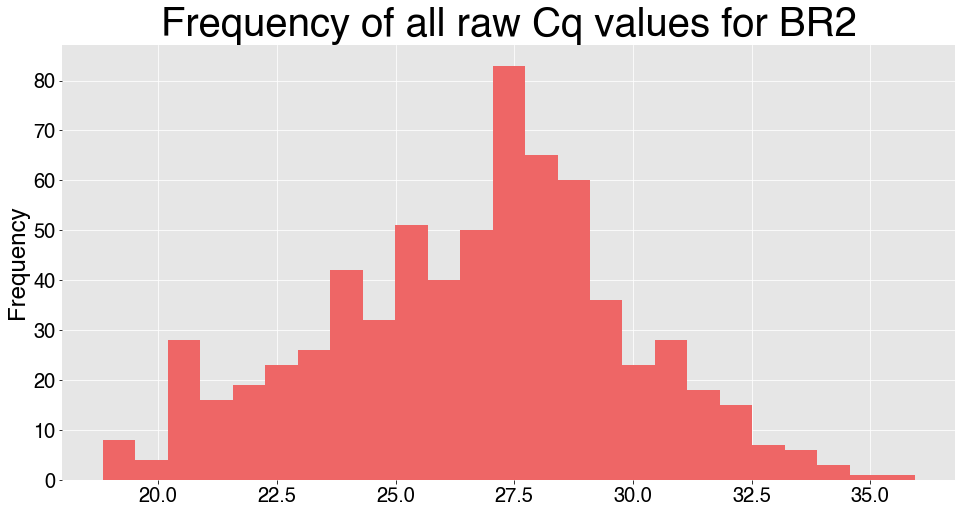

In [61]:
br2_stats["Cq"].plot(kind="hist", bins = 25)
pp.title("Frequency of all raw Cq values for BR2")
pp.show()

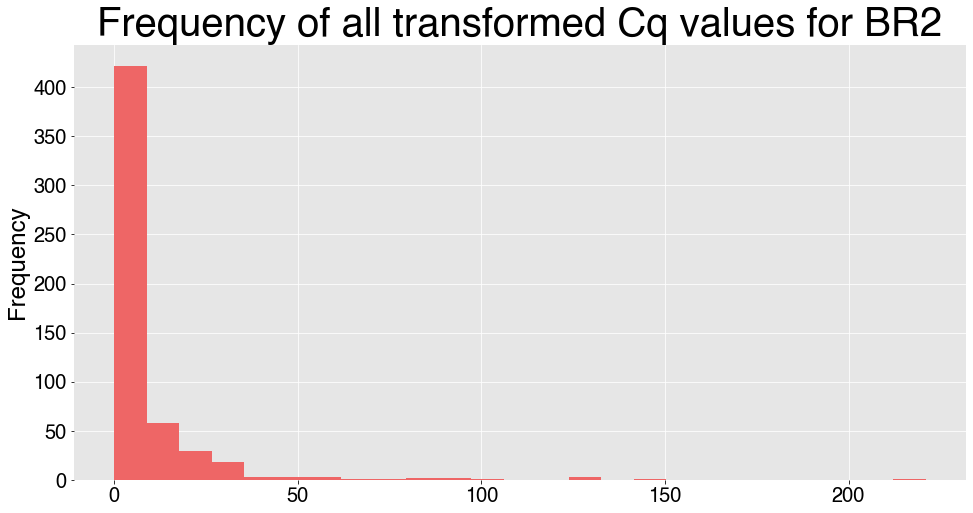

In [62]:
br2_stats["2-deltaCq"].plot(kind="hist", bins = 25)
pp.title("Frequency of all transformed Cq values for BR2")
pp.show()

In [63]:
br2_stats.loc[br2_stats["2-deltaCq"]>60]

,,2-deltaCq,Cq,deltaCq
Sample,Target,,,
I1_13B,LHY,87.419686,22.350923,-6.449886
I1_2A,LHY,100.925720,21.133646,-6.657150
I1_8A,LHY,61.455796,20.521229,-5.941477
I1_8B,LHY,97.241003,20.761128,-6.603493
I1_8C,LHY,221.037635,20.638612,-7.788148
I1_8D,LHY,124.913040,21.509466,-6.964780
I1_9C,LHY,125.161995,21.039621,-6.967653
N2_13B,LHY,142.592051,19.194977,-7.155750
N2_1B,LHY,92.220509,22.004851,-6.527016


In [64]:
br2_genegroup = br2_stats.groupby("Target")["Cq"]
br2_genegroup.describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
GAPDH,68.0,21.223406,1.372293,18.835665,20.384033,20.838326,22.019042,25.284655
LHY,69.0,24.295357,2.332489,19.194977,22.413797,24.221515,25.952249,30.235826
LUX,68.0,29.880747,1.825331,27.051478,28.154486,29.901417,31.120493,33.750189
MSI1,69.0,28.040010,0.801751,26.350727,27.374846,28.037347,28.474246,30.525447
PRDX,66.0,23.925172,1.309760,21.232940,22.861970,23.894811,24.778784,29.328409
PRR5,69.0,27.710749,2.331625,23.371317,26.084785,27.278131,29.136705,32.917367
PRR7,69.0,26.595125,1.772113,23.936132,25.191999,26.319683,27.488544,31.368247
PRR9,69.0,28.933293,3.493500,23.059883,26.191000,28.945778,31.821806,35.934719
RVE8,69.0,27.599585,2.148207,23.565247,25.945039,27.462647,29.393648,32.108169


In [65]:
IRC_4 = br_2["Target"] =="IRC1"
IRC_5 = br_2["Target"] == "IRC2"
IRC_6 = br_2["Target"] =="IRC3"

# Biological Replicate 3 <a class="anchor" id="Biological_Replicate_3"></a>

In [66]:
LHY_3 = pd.read_csv(Path("plate13_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
GAPDH_3 = pd.read_csv(Path("plate14_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
LUX_3 = pd.read_csv(Path("plate15_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR9_3 = pd.read_csv(Path("plate16_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRDX_3 = pd.read_csv(Path("plate17_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
MSI1_3 = pd.read_csv(Path("plate18_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR7_3 = pd.read_csv(Path("plate23_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
PRR5_3 = pd.read_csv(Path("plate26_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
RVE8_3 = pd.read_csv(Path("plate29_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)
TOC1_3 = pd.read_csv(Path("plate32_Cq_Results.csv"), delimiter=";", decimal=",", index_col=1)

In [67]:
genes_br_3 = [LHY_3, GAPDH_3, LUX_3, PRR9_3, PRDX_3, MSI1_3, PRR7_3, PRR5_3, RVE8_3, TOC1_3]
br_3 = pd.concat(genes_br_3)

### Cleaning up dataframe <a class="anchor" id="clean_3"></a>

In [ ]:
br_3.drop(['Well', 'Unnamed: 0',
 'Fluor',
 'Content',
 'Biological Set Name',
 'Cq Mean',
 'Cq Std. Dev',
 'Starting Quantity (SQ)',
 'Log Starting Quantity',
 'SQ Mean',
 'SQ Std. Dev',
 'Set Point',
 'Well Note'], axis=1, inplace = True)

In [68]:
br_3.reset_index(inplace = True)
br_3["Sample"] = br_3["Sample"].replace(np.nan, "NTC")
br_3["Cq"] = br_3["Cq"].replace(np.nan, 0)
br_3["Target"].replace({"GADPH":"GAPDH", "qMSI1":"MSI1"}, inplace=True)
br_3 = br_3[br_3.Cq != 0]


br_3.loc[br_3["Sample"].str.contains("IRC1"), "Target" ] = "IRC1"
br_3.loc[br_3["Sample"].str.contains("IRC2"), "Target" ] = "IRC2"
br_3.loc[br_3["Sample"].str.contains("IRC3"), "Target" ] = "IRC3"

In [72]:
High_samples_3 = br_3.loc[br_3["Cq"]>30]
High_samples_3['Sample'] = High_samples_3['Sample'].astype(str) + '_3'

High_samples_3 = High_samples_3.pivot_table(columns = "Target",
                                           index = "Sample",
                                           values = ["Cq"])

High_samples_3.to_csv('High_samples_3.csv', index = True)

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
br_3.drop([474], inplace = True)

In [74]:
br_3.loc[(br_3["Sample"] == "N2_4B") |
         (br_3["Sample"] == "I1_7B") |
         (br_3["Sample"] == "I1_13B")]

,Target,Sample,Cq
7,LHY,N2_4B,34.091629
51,LHY,I1_7B,23.475972
73,LHY,I1_13B,23.279265
87,GAPDH,N2_4B,25.809566
130,GAPDH,I1_7B,24.052774
152,GAPDH,I1_13B,23.609738
166,LUX,N2_4B,30.561547
209,LUX,I1_7B,33.367855
231,LUX,I1_13B,33.780681
245,PRR9,N2_4B,32.616937


In [75]:
# "N2_4B", "I1_7B", "I1_13B"
 
define_column_by(br_3, "Sample", "Cq", "N2_4B", 0) 
define_column_by(br_3, "Sample", "Cq", "I1_7B", 0)
define_column_by(br_3, "Sample", "Cq", "I1_13B", 0)

br_3.Cq = pd.to_numeric(br_3.Cq, errors = 'coerce')

### Pivot Table <a class="anchor" id="pivot_3"></a>

In [76]:
br_3_pivot = br_3.pivot_table(columns = "Target", 
                              index = "Sample", 
                              values = ["Cq"]).replace(0, np.NaN)

br_3_pivot.reset_index(inplace = True)
br_3_pivot.drop(columns=[('Cq', 'IRC1'), ('Cq', 'IRC2'), ('Cq', 'IRC3')], axis = 1, inplace = True)
br_3_pivot.head()

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  21.199794  24.082278  27.387362  28.405506  24.260618   
1       I1_10B  20.945094  27.163894  26.654970  27.907864  22.672588   
2       I1_10C  23.021798  24.063650  32.209401  30.021778  25.239340   
3       I1_10D  22.163318  24.882366  29.080674  28.981400  26.151735   
4       I1_11A  21.978125  25.915291  28.212231  28.882463  23.750699   

                                                               
Target       PRR5       PRR7       PRR9       RVE8       TOC1  
0       25.266311  25.728655  25.421773  27.285959  27.358890  
1       25.331053  23.524813  26.044543  30.277576  26.248092  
2             NaN  27.121343  28.900929  26.303249  30.270238  
3       27.053886  25.389578  28.908354  31.067538  27.269226  
4       25.609622  24.391864  26.328303  28.001497  28.487786

In [77]:
IRC3_list =[] 
  
for index, rows in br_3_pivot.iterrows(): 
    
     if "IRC" in rows[('Sample', '')]:
            my_list = rows[('Sample', '')]
            
            IRC3_list.append(my_list)
            
br_3_pivot = br_3_pivot[~br_3_pivot['Sample'].isin(IRC3_list)]

#### ΔCq 

In [79]:
# deltaCq = CQ (GOI) - CQ (MSI1)
br_3_pivot[('deltaCq', 'LHY')] = br_3_pivot[(    'Cq',   'LHY')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'LUX')] = br_3_pivot[(    'Cq',   'LUX')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'PRDX')] = br_3_pivot[(    'Cq',  'PRDX')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'PRR9')] = br_3_pivot[(    'Cq',  'PRR9')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'PRR7')] = br_3_pivot[(    'Cq',  'PRR7')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'PRR5')] = br_3_pivot[(    'Cq',  'PRR5')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'RVE8')] = br_3_pivot[(    'Cq',  'RVE8')].sub(br_3_pivot[(    'Cq', 'MSI1')])
br_3_pivot[('deltaCq', 'TOC1')] = br_3_pivot[(    'Cq',  'TOC1')].sub(br_3_pivot[(    'Cq', 'MSI1')])


### 2<sup>-ΔCq

In [80]:
br_3_pivot[('2-deltaCq', 'LHY')] = br_3_pivot[('deltaCq', 'LHY')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'PRDX')] = br_3_pivot[('deltaCq', 'PRDX')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'PRR9')] = br_3_pivot[('deltaCq', 'PRR9')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'LUX')] = br_3_pivot[('deltaCq', 'LUX')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'PRR7')] = br_3_pivot[('deltaCq', 'PRR7')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'PRR5')] = br_3_pivot[('deltaCq', 'PRR5')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'RVE8')] = br_3_pivot[('deltaCq', 'RVE8')].apply(lambda x: 2 ** -(x))
br_3_pivot[('2-deltaCq', 'TOC1')] = br_3_pivot[('deltaCq', 'TOC1')].apply(lambda x: 2 ** -(x))

In [81]:
br_3_pivot.head()

Sample         Cq                                              \
Target              GAPDH        LHY        LUX       MSI1       PRDX   
0       I1_10A  21.199794  24.082278  27.387362  28.405506  24.260618   
1       I1_10B  20.945094  27.163894  26.654970  27.907864  22.672588   
2       I1_10C  23.021798  24.063650  32.209401  30.021778  25.239340   
3       I1_10D  22.163318  24.882366  29.080674  28.981400  26.151735   
4       I1_11A  21.978125  25.915291  28.212231  28.882463  23.750699   
..         ...        ...        ...        ...        ...        ...   
98       N2_8D  21.331633  21.191094  32.537728  28.445115  23.655516   
99       N2_9A  20.025151  21.989913  28.440829  27.387171  22.454228   
100      N2_9B  20.401996  24.087338  26.905250  27.593200  23.245978   
101      N2_9C  22.048292  23.314570  29.515139  28.638379  25.709794   
102      N2_9D  21.039848  21.793564  31.666405  28.106467  23.834844   

                                                    ...   deltaCq            \
Target       PRR5       PRR7       PRR9       RVE8  ...      RVE8      TOC1   
0       25.266311  25.728655  25.421773  27.285959  ... -1.119547 -1.046616   
1       25.331053  23.524813  26.044543  30.277576  ...  2.369713 -1.659771   
2             NaN  27.121343  28.900929  26.303249  ... -3.718529  0.248460   
3       27.053886  25.389578  28.908354  31.067538  ...  2.086138 -1.712174   
4       25.609622  24.391864  26.328303  28.001497  ... -0.880966 -0.394677   
..            ...        ...        ...        ...  ...       ...       ...   
98      27.824568  26.908187  27.813326  24.663867  ... -3.781247  0.620456   
99      23.792771  24.195935  23.451565  24.909666  ... -2.477505 -0.565386   
100     24.135683  24.182570  22.956668  27.871579  ...  0.278379 -0.164491   
101     26.024779  25.991339  27.808122  25.978434  ... -2.659945 -0.431457   
102     27.408761  27.157224  29.137730  24.546936  ... -3.559531  0.302630   

         2-deltaCq                                                        \
Target         LHY       PRDX       PRR9       LUX       PRR7       PRR5   
0        20.018027  17.690313   7.910302  2.025311   6.394587   8.810324   
1         1.674777  37.668199   3.638441  2.383190  20.865535   5.966194   
2        62.169184  27.520551   2.174749  0.219513   7.466512        NaN   
3        17.136893   7.109088   1.051935  0.933502  12.057190   3.803990   
4         7.820015  35.060235   5.873253  1.591328  22.480445   9.665478   
..             ...        ...        ...       ...        ...        ...   
98      152.643336  27.657505   1.549485  0.058614   2.901759   1.537458   
99       42.144069  30.546656  15.301546  0.481745   9.133933  12.078752   
100      11.359770  20.353736  24.873403  1.610992  10.634124  10.985406   
101      40.052179   7.613630   1.778002  0.544589   6.263806   6.120290   
102      79.501101  19.314634   0.489281  0.084791   1.930859   1.621923   

                             
Target       RVE8      TOC1  
0        2.172787  2.065679  
1        0.193484  3.159664  
2       13.164030  0.841794  
3        0.235510  3.276542  
4        1.841608  1.314648  
..            ...       ...  
98      13.748930  0.650465  
99       5.569334  1.479784  
100      0.824517  1.120771  
101      6.320088  1.348595  
102     11.790320  0.810773  

[75 rows x 27 columns]

In [82]:
br3_stats = br_3_pivot.set_index("Sample").swaplevel(0,1,axis =1).stack(level=0)
br3_stats.head()

2-deltaCq         Cq   deltaCq
Sample Target                                
I1_10A GAPDH         NaN  21.199794       NaN
       LHY     20.018027  24.082278 -4.323228
       LUX      2.025311  27.387362 -1.018144
       MSI1          NaN  28.405506       NaN
       PRDX    17.690313  24.260618 -4.144888
...                  ...        ...       ...
N2_9D  PRR5     1.621923  27.408761 -0.697705
       PRR7     1.930859  27.157224 -0.949243
       PRR9     0.489281  29.137730  1.031263
       RVE8    11.790320  24.546936 -3.559531
       TOC1     0.810773  28.409097  0.302630

[705 rows x 3 columns]

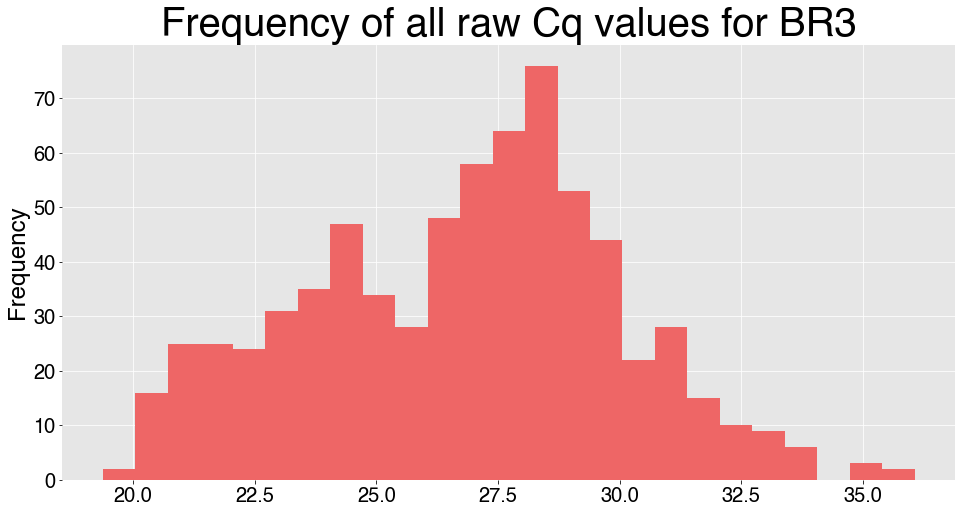

In [83]:
br3_stats["Cq"].plot(kind="hist", bins = 25)
pp.title("Frequency of all raw Cq values for BR3")
pp.show()

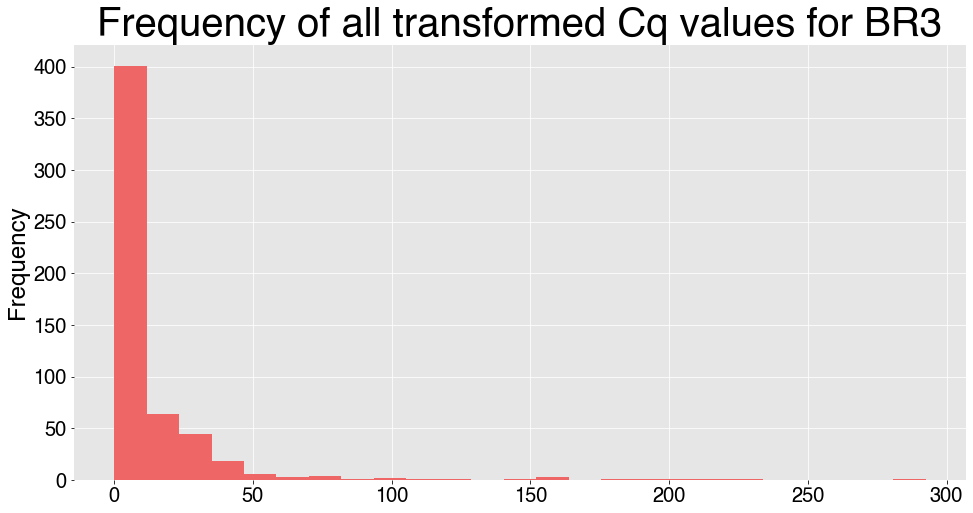

In [84]:
br3_stats["2-deltaCq"].plot(kind="hist", bins = 25)
pp.title("Frequency of all transformed Cq values for BR3")
pp.show()

In [85]:
br3_stats.loc[br3_stats["2-deltaCq"]>200]

,,2-deltaCq,Cq,deltaCq
Sample,Target,,,
I1_2B,LHY,221.232132,20.666674,-7.789417
I1_8B,LHY,292.521491,22.304677,-8.192399
I1_8C,LHY,209.593823,21.027315,-7.711452
I1_8D,LHY,230.808668,20.422403,-7.850554


In [86]:
br3_genegroup = br3_stats.groupby("Target")["Cq"]
br3_genegroup.describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
GAPDH,71.0,21.656699,1.096900,19.379093,20.871524,21.523888,22.216334,24.650082
LHY,72.0,24.274221,2.382212,20.258769,22.259847,24.084808,26.205234,29.202807
LUX,71.0,29.778325,1.858602,26.505149,28.356620,29.537340,31.099556,36.067482
MSI1,71.0,28.765397,0.965363,26.899708,28.117990,28.566440,29.366762,31.627026
PRDX,72.0,24.410354,1.628858,21.513085,23.225056,24.063329,25.494601,28.864324
PRR5,68.0,27.796954,2.572357,22.970909,26.187329,27.420039,29.248684,33.402226
PRR7,69.0,26.674672,1.796834,23.524813,25.389578,26.479361,28.032654,30.796707
PRR9,71.0,29.178895,3.493380,22.482635,26.355645,29.576540,31.506791,35.795134
RVE8,70.0,26.936554,2.388180,23.013391,24.850892,26.582327,28.422987,32.288968


In [87]:
IRC_7 = br_3["Target"] =="IRC1"
IRC_8 = br_3["Target"] == "IRC2"
IRC_9 = br_3["Target"] =="IRC3"

# Inter-Run Calibrators <a class="anchor" id="IRC"></a>

* Group IRC's by plate
* Fit Ordinary Least Squares (OLS) regression model using an estimation method
    * estimate relationship between plate and Cq values

In [88]:
br_1_IRC = br_1.loc[IRC_1 | IRC_2 | IRC_3]
br_2_IRC = br_2.loc[IRC_4 | IRC_5 | IRC_6]
br_3_IRC = br_3.loc[IRC_7 | IRC_8 | IRC_9]
IRCs = [br_1_IRC,br_2_IRC, br_3_IRC]
IRC_data = pd.concat(IRCs)
IRC_data

,index,Target,Sample,Cq
76,78.0,IRC1,IRC1_1,22.057487
77,79.0,IRC2,IRC2_1,22.060055
78,80.0,IRC3,IRC3_1,20.106430
154,159.0,IRC1,IRC1_2,24.750765
155,160.0,IRC2,IRC2_2,24.195954
...,...,...,...,...
638,NaN,IRC3,IRC3_26,22.011905
713,NaN,IRC1,IRC1_29,22.594197
714,NaN,IRC2,IRC2_29,23.325853
715,NaN,IRC3,IRC3_29,21.534339


In [89]:
IRC_data["Plate"] = None
define_column_by(IRC_data, "Sample", "Plate", "_1", "1")
define_column_by(IRC_data, "Sample", "Plate", "_2", "2")
define_column_by(IRC_data, "Sample", "Plate", "_4", "4")
define_column_by(IRC_data, "Sample", "Plate", "_5", "5")
define_column_by(IRC_data, "Sample", "Plate", "_6", "6")
define_column_by(IRC_data, "Sample", "Plate", "_7", "7")
define_column_by(IRC_data, "Sample", "Plate", "_8", "8")
define_column_by(IRC_data, "Sample", "Plate", "_10", "10")
define_column_by(IRC_data, "Sample", "Plate", "_11", "11")
define_column_by(IRC_data, "Sample", "Plate", "_12", "12")
define_column_by(IRC_data, "Sample", "Plate", "_13", "13")
define_column_by(IRC_data, "Sample", "Plate", "_14", "14")
define_column_by(IRC_data, "Sample", "Plate", "_15", "15")
define_column_by(IRC_data, "Sample", "Plate", "_16", "16")
define_column_by(IRC_data, "Sample", "Plate", "_17", "17")
define_column_by(IRC_data, "Sample", "Plate", "_18", "18")
define_column_by(IRC_data, "Sample", "Plate", "_19", "19")
define_column_by(IRC_data, "Sample", "Plate", "_20", "20")
define_column_by(IRC_data, "Sample", "Plate", "_21", "21")
define_column_by(IRC_data, "Sample", "Plate", "_22", "22")
define_column_by(IRC_data, "Sample", "Plate", "_23", "23")
define_column_by(IRC_data, "Sample", "Plate", "_24", "24")
define_column_by(IRC_data, "Sample", "Plate", "_25", "25")
define_column_by(IRC_data, "Sample", "Plate", "_26", "26")
define_column_by(IRC_data, "Sample", "Plate", "_27", "27")
define_column_by(IRC_data, "Sample", "Plate", "_28", "28")
define_column_by(IRC_data, "Sample", "Plate", "_29", "29")
define_column_by(IRC_data, "Sample", "Plate", "_32", "30")
define_column_by(IRC_data, "Sample", "Plate", "_31", "31")
define_column_by(IRC_data, "Sample", "Plate", "_32", "32")

,index,Target,Sample,Cq,Plate
76,78.0,IRC1,IRC1_1,22.057487,1
77,79.0,IRC2,IRC2_1,22.060055,1
78,80.0,IRC3,IRC3_1,20.106430,1
154,159.0,IRC1,IRC1_2,24.750765,2
155,160.0,IRC2,IRC2_2,24.195954,2
...,...,...,...,...,...
638,NaN,IRC3,IRC3_26,22.011905,26
713,NaN,IRC1,IRC1_29,22.594197,29
714,NaN,IRC2,IRC2_29,23.325853,29
715,NaN,IRC3,IRC3_29,21.534339,29


In [90]:
IRC_data.Plate = pd.to_numeric(IRC_data.Plate, errors = 'coerce')
IRC_data.sort_values("Plate", inplace = True)

In [91]:
target_groups = IRC_data["Cq"].groupby(IRC_data["Target"])

In [92]:
rp.summary_cont(target_groups)

,N,Mean,SD,SE,95% Conf.,Interval
Target,,,,,,
IRC1,29,22.572220,0.573818,0.106555,22.359675,22.784765
IRC2,28,23.283885,0.868050,0.164046,22.956455,23.611315
IRC3,28,21.820400,0.735395,0.138976,21.543007,22.097792


The IRC's were tested on every plate using the same samples (I1_5A, I1_5B, and I1_6A) with GAPDH. The mean Cq values for each were 22.6, 23.28, and 21.8 indicating that each sample will have natural slightly different expression levels and patterns for the same gene. 

In [93]:
plate_groups = IRC_data["Cq"].groupby(IRC_data["Plate"])

In [94]:
rp.summary_cont(plate_groups)

,N,Mean,SD,SE,95% Conf.,Interval
Plate,,,,,,
1.0,3,21.407991,1.127186,0.650781,19.845791,22.970190
2.0,3,23.479097,1.744312,1.007079,21.061604,25.896591
5.0,3,22.721634,0.954529,0.551098,21.398725,24.044544
6.0,3,22.060589,0.530431,0.306244,21.325450,22.795729
7.0,3,22.342890,0.622602,0.359459,21.480008,23.205772
8.0,3,21.773920,0.598857,0.345750,20.943947,22.603894
10.0,3,24.358762,2.024746,1.168988,21.552607,27.164917
11.0,3,23.138905,0.562286,0.324636,22.359617,23.918194
12.0,3,22.716590,0.633330,0.365653,21.838840,23.594340


In [95]:
IRC_model = ols('Cq ~ C(Plate)', data = IRC_data).fit()
IRC_anova_table = sm.stats.anova_lm(IRC_model, typ=2)
IRC_anova_table

,sum_sq,df,F,PR(>F)
C(Plate),32.849201,27.0,1.629279,0.063561
Residual,40.323613,54.0,NaN,NaN


A p-value of 0.06 indicates no significant differences between plates and all data can be compared as if it were in the same run. 

# Merged Data <a class="anchor" id="Merge"></a>

### Merged data for pivot tables

In [96]:
raw_1_2 = pd.merge(br_1_pivot, br_2_pivot, 'left', on = [('Sample', '')], suffixes = ('_1', '_2'))

raw_merge = pd.merge(raw_1_2, br_3_pivot, 'left', on = [('Sample', '')])

raw_merge.rename(columns = {'Cq' : 'Cq_3', 'deltaCq' : 'deltaCq_3', '2-deltaCq' : '2-deltaCq_3'}, inplace = True)

Reorganize so all the genes are together, and take the average Cq across the replicates.

In [97]:
raw_merge.set_index("Sample", inplace = True)
raw_merge = raw_merge.swaplevel(axis=1)
raw_merge = raw_merge.sort_index(level=0, axis=1)
raw_merge.columns.names = ['Target', 'Cq']

In [98]:
raw_merge.head()

Target      GAPDH                               LHY                          \
Cq           Cq_1       Cq_2       Cq_3 2-deltaCq_1 2-deltaCq_2 2-deltaCq_3   
Sample                                                                        
I1_10A  21.278777  20.255816  21.199794    5.942962    9.448637   20.018027   
I1_10B  23.274071        NaN  20.945094    0.422237         NaN    1.674777   
I1_10C  24.537939  21.785989  23.021798   20.884935   39.211045   62.169184   
I1_10D  22.188337  21.714277  22.163318    2.944517   10.679168   17.136893   
I1_11A  24.549344  20.362863  21.978125    0.635398    1.836074    7.820015   

Target                                             ...      RVE8        TOC1  \
Cq           Cq_1       Cq_2       Cq_3 deltaCq_1  ... deltaCq_3 2-deltaCq_1   
Sample                                             ...                         
I1_10A  24.282946  24.219553  24.082278 -2.571182  ... -1.119547    0.869967   
I1_10B  29.882935        NaN  27.163894  1.243874  ...  2.369713    1.201130   
I1_10C  24.631841  23.100849  24.063650 -4.384391  ... -3.718529    0.322284   
I1_10D  25.568140  25.003050  24.882366 -1.558031  ...  2.086138    0.063439   
I1_11A  30.533012  27.257716  25.915291  0.654268  ... -0.880966    1.487289   

Target                                                                     \
Cq     2-deltaCq_2 2-deltaCq_3       Cq_1       Cq_2       Cq_3 deltaCq_1   
Sample                                                                      
I1_10A    1.861977    2.065679  27.055095  26.562824  27.358890  0.200967   
I1_10B         NaN    3.159664  28.374669        NaN  26.248092 -0.264392   
I1_10C    0.667824    0.841794  30.649828  28.976498  30.270238  1.633595   
I1_10D    1.935816    3.276542  31.104646  27.466835  27.269226  3.978475   
I1_11A    2.247593    1.314648  29.306058  26.965960  28.487786 -0.572685   

Target                      
Cq     deltaCq_2 deltaCq_3  
Sample                      
I1_10A -0.896835 -1.046616  
I1_10B       NaN -1.659771  
I1_10C  0.582461  0.248460  
I1_10D -0.952942 -1.712174  
I1_11A -1.168381 -0.394677  

[5 rows x 78 columns]

Cq_1, Cq_2, and Cq_3 represent the 3 biological replicates. 

In [101]:
raw_merge.reset_index(inplace=True)
raw_merge.loc[raw_merge["Sample"] == "I1_10A", ["LHY"]]

Target         LHY                                                           \
Cq     2-deltaCq_1 2-deltaCq_2 2-deltaCq_3       Cq_1       Cq_2       Cq_3   
0         5.942962    9.448637   20.018027  24.282946  24.219553  24.082278   

Target                                
Cq     deltaCq_1 deltaCq_2 deltaCq_3  
0      -2.571182 -3.240106 -4.323228

### Set Clone, treatment, and zeitgeber columns <a class="anchor" id="sample_ids"></a>

In [102]:
# Set Clone, treatment, and timepoint
raw_merge["Clone"] = None
define_column_by(raw_merge, "Sample", "Clone", "I1", "I1")
define_column_by(raw_merge, "Sample", "Clone", "N2", "N2")

## Set treatment to rows
raw_merge["treatment"] = None
define_column_by(raw_merge, "Sample", "treatment", "A", "Norway")
define_column_by(raw_merge, "Sample", "treatment", "B", "Italy")
define_column_by(raw_merge, "Sample", "treatment", "C", "DD-Norway")
define_column_by(raw_merge, "Sample", "treatment", "D", "DD-Italy")

### Set timepoint
raw_merge["zeitgeber"] = None
define_column_by(raw_merge, "Sample", "zeitgeber", "_1", "0")
define_column_by(raw_merge, "Sample", "zeitgeber", "_2", "4")
define_column_by(raw_merge, "Sample", "zeitgeber", "_3", "8")
define_column_by(raw_merge, "Sample", "zeitgeber", "_4", "12")
define_column_by(raw_merge, "Sample", "zeitgeber", "_5", "16")
define_column_by(raw_merge, "Sample", "zeitgeber", "_6", "20")
define_column_by(raw_merge, "Sample", "zeitgeber", "_7", "24")
define_column_by(raw_merge, "Sample", "zeitgeber", "_8", "28")
define_column_by(raw_merge, "Sample", "zeitgeber", "_9", "32")
define_column_by(raw_merge, "Sample", "zeitgeber", "_10", "36")
define_column_by(raw_merge, "Sample", "zeitgeber", "_11", "40")
define_column_by(raw_merge, "Sample", "zeitgeber", "_12", "44")
define_column_by(raw_merge, "Sample", "zeitgeber", "_13", "48")

raw_merge.head()

Target  Sample      GAPDH                               LHY              \
Cq                   Cq_1       Cq_2       Cq_3 2-deltaCq_1 2-deltaCq_2   
0       I1_10A  21.278777  20.255816  21.199794    5.942962    9.448637   
1       I1_10B  23.274071        NaN  20.945094    0.422237         NaN   
2       I1_10C  24.537939  21.785989  23.021798   20.884935   39.211045   
3       I1_10D  22.188337  21.714277  22.163318    2.944517   10.679168   
4       I1_11A  24.549344  20.362863  21.978125    0.635398    1.836074   
..         ...        ...        ...        ...         ...         ...   
71       N2_8D  20.396178  22.107654  21.331633  124.178668   76.147403   
72       N2_9A  21.336921  22.327989  20.025151   24.401639   20.093950   
73       N2_9B  20.724947  20.725393  20.401996    1.851548    5.861889   
74       N2_9C  21.899637  20.807252  22.048292   61.483843  132.483414   
75       N2_9D  22.729776  25.284655  21.039848   25.300575   47.141295   

Target                                               ...        TOC1  \
Cq     2-deltaCq_3       Cq_1       Cq_2       Cq_3  ... 2-deltaCq_3   
0        20.018027  24.282946  24.219553  24.082278  ...    2.065679   
1         1.674777  29.882935        NaN  27.163894  ...    3.159664   
2        62.169184  24.631841  23.100849  24.063650  ...    0.841794   
3        17.136893  25.568140  25.003050  24.882366  ...    3.276542   
4         7.820015  30.533012  27.257716  25.915291  ...    1.314648   
..             ...        ...        ...        ...  ...         ...   
71      152.643336  19.623235  20.882354  21.191094  ...    0.650465   
72       42.144069  22.277157  22.732500  21.989913  ...    1.479784   
73       11.359770  25.105930  24.823480  24.087338  ...    1.120771   
74       40.052179  22.213453  21.283328  23.314570  ...    1.348595   
75       79.501101  22.430877  21.653556  21.793564  ...    0.810773   

Target                                                                Clone  \
Cq           Cq_1       Cq_2       Cq_3 deltaCq_1 deltaCq_2 deltaCq_3         
0       27.055095  26.562824  27.358890  0.200967 -0.896835 -1.046616    I1   
1       28.374669        NaN  26.248092 -0.264392       NaN -1.659771    I1   
2       30.649828  28.976498  30.270238  1.633595  0.582461  0.248460    I1   
3       31.104646  27.466835  27.269226  3.978475 -0.952942 -1.712174    I1   
4       29.306058  26.965960  28.487786 -0.572685 -1.168381 -0.394677    I1   
..            ...        ...        ...       ...       ...       ...   ...   
71      28.221951  28.737377  29.065571  1.642443  1.604300  0.620456    N2   
72      27.603507  27.444216  26.821784  0.717444  0.383027 -0.565386    N2   
73      27.245141  27.932923  27.428709  1.250479  0.558078 -0.164491    N2   
74      28.003486  28.804181  28.206921 -0.152102  0.471186 -0.431457    N2   
75      27.803615  27.418961  28.409097  0.711640  0.206485  0.302630    N2   

Target  treatment zeitgeber  
Cq                           
0          Norway        36  
1           Italy        36  
2       DD-Norway        36  
3        DD-Italy        36  
4          Norway        40  
..            ...       ...  
71       DD-Italy        28  
72         Norway        32  
73          Italy        32  
74      DD-Norway        32  
75       DD-Italy        32  

[76 rows x 82 columns]

In [103]:
raw_merge.zeitgeber = pd.to_numeric(raw_merge.zeitgeber, errors = 'coerce')
raw_merge.sort_values("zeitgeber", inplace = True)
raw_merge.set_index(["Clone", "Sample", "treatment", "zeitgeber"], drop = True, inplace = True)

# Reference genes <a class="anchor" id="ref_genes"></a>

In [104]:
ref_genes = raw_merge[["GAPDH", "MSI1"]]
ref_genes = ref_genes.copy()

In [105]:
# Mean Cq
ref_genes[('GAPDH',  'Mean')] = np.nanmean((ref_genes[(  'GAPDH',   'Cq_1')], 
                                            ref_genes[(  'GAPDH',   'Cq_2')], 
                                            ref_genes[(  'GAPDH',   'Cq_3')]), axis = 0)

ref_genes[('MSI1',  'Mean')] = np.nanmean((ref_genes[(  'MSI1',   'Cq_1')], 
                                           ref_genes[(  'MSI1',   'Cq_2')], 
                                           ref_genes[(  'MSI1',   'Cq_3')]), axis = 0)

In [106]:
ref_genes = ref_genes.stack(level=0)
ref_genes = ref_genes.unstack().swaplevel(0,1,axis = 1).sort_index(axis=1)
ref_genes.sort_values("zeitgeber", inplace = True)

In [107]:
ref_genes.head()

Target                                GAPDH                                   \
Cq                                     Cq_1       Cq_2       Cq_3       Mean   
Clone Sample treatment zeitgeber                                               
N2    N2_1A  Norway    0          21.430556        NaN  20.595556  21.013056   
      N2_1B  Italy     0          19.607571  20.368138  21.782572  20.586094   
I1    I1_1B  Italy     0          22.852806        NaN  21.715142  22.283974   
      I1_1A  Norway    0          21.834811        NaN  22.004871  21.919841   
N2    N2_2A  Norway    4          20.792569  20.458024  20.176330  20.475641   

Target                                 MSI1                                   
Cq                                     Cq_1       Cq_2       Cq_3       Mean  
Clone Sample treatment zeitgeber                                              
N2    N2_1A  Norway    0          28.762125        NaN  27.766517  28.264321  
      N2_1B  Italy     0          26.481669  28.531866  29.522312  28.178616  
I1    I1_1B  Italy     0          28.920904        NaN  28.550151  28.735527  
      I1_1A  Norway    0          27.725956        NaN  28.621726  28.173841  
N2    N2_2A  Norway    4          28.330928  28.955281  27.822580  28.369596

In [108]:
ref_genes.reset_index(inplace = True)

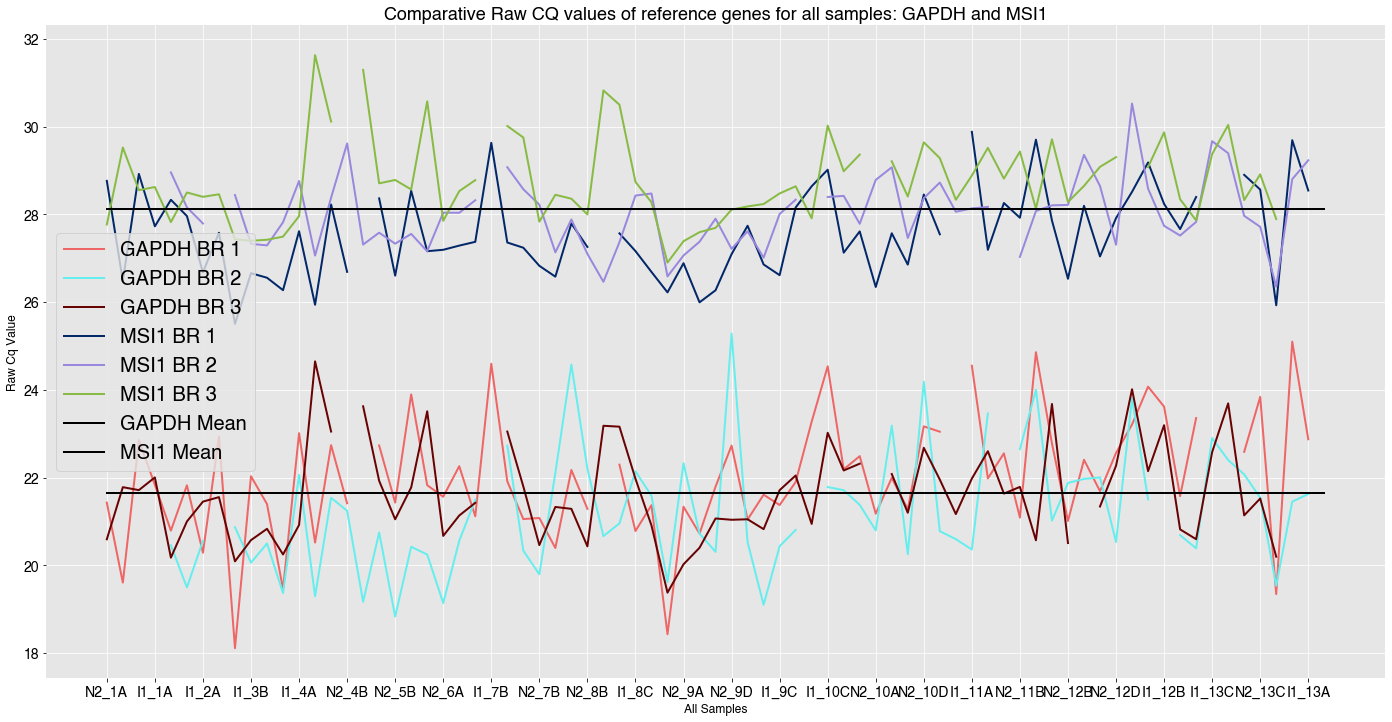

In [109]:
fig = pp.figure(figsize=(24,12))

samp = ref_genes[(   'Sample',     '')]

g1=ref_genes[('GAPDH', 'Cq_1')] 
g2=ref_genes[('GAPDH', 'Cq_2')]
g3=ref_genes[('GAPDH', 'Cq_3')]

q1=ref_genes[('MSI1', 'Cq_1')]
q2=ref_genes[('MSI1', 'Cq_2')]
q3=ref_genes[('MSI1', 'Cq_3')]


pp.plot(samp, g1, label = "GAPDH BR 1")
pp.plot(samp, g2, label = "GAPDH BR 2")
pp.plot(samp, g3, label = "GAPDH BR 3")

pp.plot(samp, q1, label = "MSI1 BR 1")
pp.plot(samp, q2, label = "MSI1 BR 2")
pp.plot(samp, q3, label = "MSI1 BR 3")

pp.plot([0,76] , [21.64,21.64], color = 'black', label = "GAPDH Mean")
pp.plot([0,76], [28.11, 28.11], color = 'black', label = "MSI1 Mean")

pp.xlabel("All Samples", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.ylabel("Raw Cq Value", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.xticks(samp[::3], fontsize=14)
pp.yticks(fontsize=14)
pp.title("Comparative Raw Cq values of reference genes for all samples: GAPDH and MSI1", fontdict = {'fontweight' : 'bold', 'fontsize' : 18})
pp.legend(loc='best')
pp.show()

Cq values of reference genes appear to vary somewhat among samples, which means the initial RNA/cDNA concentration levels might be slightly different among samples. Some samples have very high Cq's, could be due to previous steps in RNA isolation or cDNA synthesis. 

In [110]:
print(f"Mean of MSI1 Cq: {ref_genes[('MSI1',  'Mean')].mean()} standard deviation: {ref_genes[('MSI1',  'Mean')].std()}") 
print(f"Mean of GAPDH Cq: {ref_genes[('GAPDH',  'Mean')].mean()} standard deviation: {ref_genes[('GAPDH',  'Mean')].std()}") 


Mean of MSI1 Cq: 28.174522846822157 standard deviation: 0.6815610081925728
Mean of GAPDH Cq: 21.684541855277413 standard deviation: 1.0027655728114988


The primer efficiency values were about the same for MSI1 (117%) and GAPDH (116%). 

In [111]:
ref_genes.loc[(ref_genes[(    'MSI1', 'Cq_1')]>28.17 + (3*0.68)) | (ref_genes[(    'GAPDH', 'Cq_1')]>21.68 + (3*1.00))]

Target Clone  Sample treatment zeitgeber      GAPDH                       \
Cq                                             Cq_1       Cq_2      Cq_3   
58        N2  N2_11A    Norway        40  24.858481  24.000210  20.57229   
74        I1  I1_13B     Italy        48  25.099793  21.451491       NaN   

Target                  MSI1                                   
Cq           Mean       Cq_1       Cq_2       Cq_3       Mean  
58      23.143660  29.701271  28.074753  28.129514  28.635179  
74      23.275642  29.689602  28.800809        NaN  29.245206

In [112]:
ref_genes.loc[(ref_genes[(    'MSI1', 'Cq_2')]>28.17 + (3*0.68)) | (ref_genes[(    'GAPDH', 'Cq_2')]>21.68 + (3*1.00))]

Target Clone  Sample treatment zeitgeber      GAPDH                        \
Cq                                             Cq_1       Cq_2       Cq_3   
39        N2   N2_9D  DD-Italy        32  22.729776  25.284655  21.039848   
64        I1  I1_12D  DD-Italy        44  23.210955  23.808744  24.013883   

Target                  MSI1                                   
Cq           Mean       Cq_1       Cq_2       Cq_3       Mean  
39      23.018093  27.091975  27.212476  28.106467  27.470306  
64      23.677861  28.512673  30.525447        NaN  29.519060

In [113]:
ref_genes.loc[(ref_genes[(    'MSI1', 'Cq_3')]>28.17 + (3*0.68)) | (ref_genes[(    'GAPDH', 'Cq_3')]>21.68 + (3*1.00))]

Target Clone Sample treatment zeitgeber      GAPDH                        \
Cq                                            Cq_1       Cq_2       Cq_3   
13        N2  N2_4A    Norway        12  20.519908  19.298163  24.650082   
16        N2  N2_5A    Norway        16        NaN  19.170990  23.624839   
20        I1  I1_6B     Italy        20  21.827861  20.247831  23.512045   
31        I1  I1_8A    Norway        28        NaN  20.667047  23.181410   
32        I1  I1_8B     Italy        28  22.295691  20.958142  23.160995   

Target                  MSI1                                   
Cq           Mean       Cq_1       Cq_2       Cq_3       Mean  
13      21.489384  25.938962  27.058773  31.627026  28.208254  
16      21.397914        NaN  27.311284  31.290393  29.300839  
20      21.862579  27.159791  27.156674  30.574420  28.296961  
31      21.924229        NaN  26.462706  30.823422  28.643064  
32      22.138276  27.566045  27.364621  30.497075  28.475914

Samples that still may be considered to be dropped because of outlying Cq values for reference genes: I1 13B_1, N2 11A_1, I1 6B_3, I1 8A_3, I1 8B_3.

In [114]:
ref_genes.set_index(["Clone", "Sample", "zeitgeber", "treatment"], inplace = True)
ref_genes.describe()

Target      GAPDH                                        MSI1             \
Cq           Cq_1       Cq_2       Cq_3       Mean       Cq_1       Cq_2   
count   71.000000  68.000000  71.000000  76.000000  71.000000  69.000000   
mean    21.989032  21.223406  21.656699  21.684542  27.571489  28.040010   
std      1.391297   1.372293   1.096900   1.002766   1.002897   0.801751   
min     18.114577  18.835665  19.379093  19.144770  25.503145  26.350727   
25%     21.228395  20.384033  20.871524  21.006743  26.757389  27.374846   
50%     21.899637  20.838326  21.523888  21.733958  27.566045  28.037347   
75%     22.816155  22.019042  22.216334  22.298038  28.294132  28.474246   
max     25.099793  25.284655  24.650082  24.594568  29.878743  30.525447   

Target                        
Cq           Cq_3       Mean  
count   71.000000  76.000000  
mean    28.765397  28.174523  
std      0.965363   0.681561  
min     26.899708  26.568718  
25%     28.117990  27.688988  
50%     28.566440  28.199965  
75%     29.366762  28.596342  
max     31.627026  29.713912

In [115]:
ref_genes.reset_index(inplace = True)
ref_genes.columns

MultiIndex([(    'Clone',     ''),
            (   'Sample',     ''),
            ('zeitgeber',     ''),
            ('treatment',     ''),
            (    'GAPDH', 'Cq_1'),
            (    'GAPDH', 'Cq_2'),
            (    'GAPDH', 'Cq_3'),
            (    'GAPDH', 'Mean'),
            (     'MSI1', 'Cq_1'),
            (     'MSI1', 'Cq_2'),
            (     'MSI1', 'Cq_3'),
            (     'MSI1', 'Mean')],
           names=['Target', 'Cq'])

In [116]:
N2_ref = ref_genes.loc[ref_genes["Clone"] == "N2"]
N2_ref.columns = [' '.join(col).strip() for col in N2_ref.columns.values]
I1_ref =  ref_genes.loc[ref_genes["Clone"] == "I1"]
I1_ref.columns = [' '.join(col).strip() for col in I1_ref.columns.values]
N2_ref.columns

Index(['Clone', 'Sample', 'zeitgeber', 'treatment', 'GAPDH Cq_1', 'GAPDH Cq_2',
       'GAPDH Cq_3', 'GAPDH Mean', 'MSI1 Cq_1', 'MSI1 Cq_2', 'MSI1 Cq_3',
       'MSI1 Mean'],
      dtype='object')

## MSI1 <a class="anchor" id="treat_M"></a>

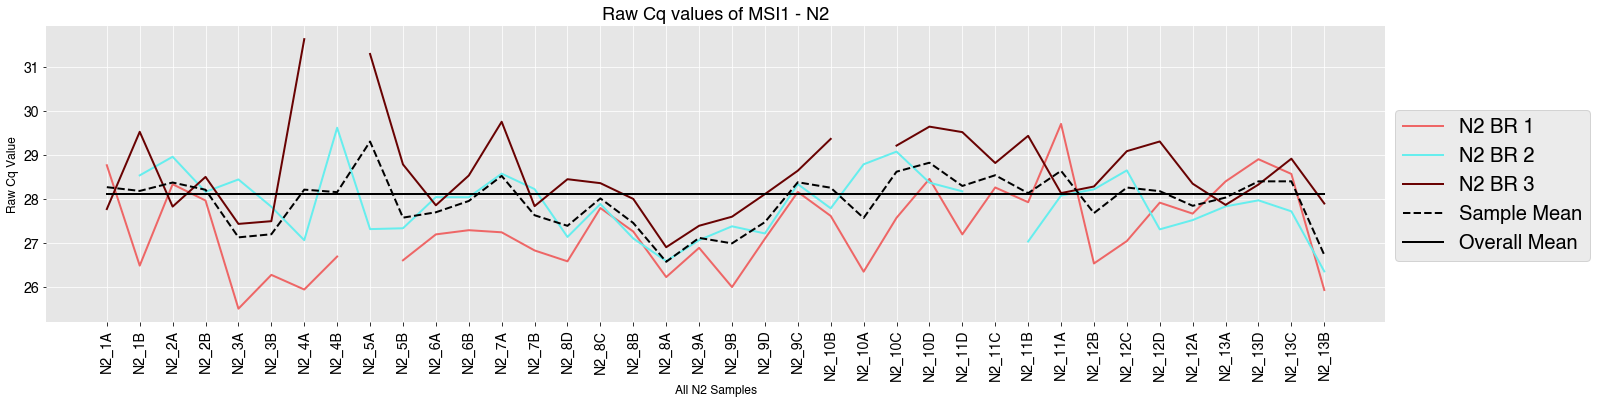

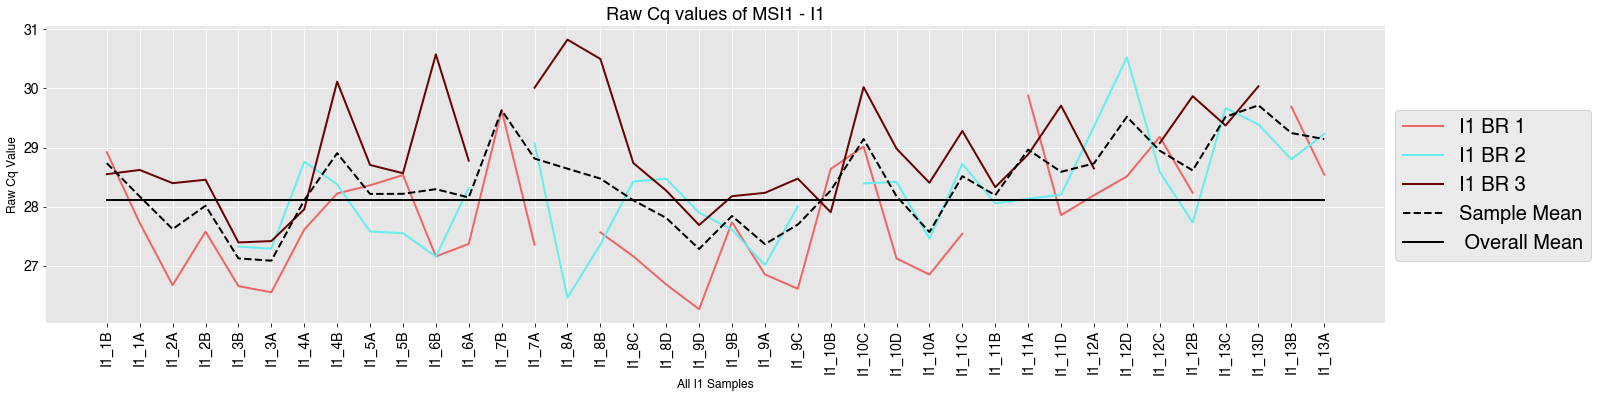

In [117]:
I1_q = ref_genes.loc[ref_genes[(   'Clone',     '')] == "I1"]
N2_q = ref_genes.loc[ref_genes[(   'Clone',     '')] == "N2"]

fig = pp.figure(figsize=(24,12))
pp.subplot(2, 1, 1) # n_rows, n_columns, current plot
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'MSI1', 'Cq_1')], label = "N2 BR 1")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'MSI1', 'Cq_2')], label = "N2 BR 2")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'MSI1', 'Cq_3')], label = "N2 BR 3")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'MSI1', 'Mean')], color = "black", linestyle = "dashed", label = "Sample Mean")
pp.plot([0,37], [28.11, 28.11], color = "black", label = "Overall Mean")

pp.xlabel("All N2 Samples", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.ylabel("Raw Cq Value", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.xticks(N2_q[(   'Sample',     '')], fontsize=14, rotation=90)
pp.yticks(fontsize=14)
pp.title("Raw Cq values of MSI1 - N2", fontdict = {'fontweight' : 'bold', 'fontsize' : 18})
pp.legend(bbox_to_anchor=(1,0.75))



fig = pp.figure(figsize=(24,12))
pp.subplot(2, 1, 2)
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'MSI1', 'Cq_1')], label = "I1 BR 1")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'MSI1', 'Cq_2')], label = "I1 BR 2")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'MSI1', 'Cq_3')], label = "I1 BR 3")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'MSI1', 'Mean')], color = "black", linestyle = "dashed", label = "Sample Mean")
pp.plot([0,37], [28.11, 28.11], color = "black", label = " Overall Mean")

pp.xlabel("All I1 Samples", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.ylabel("Raw Cq Value", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.xticks(I1_q[(   'Sample',     '')], fontsize=14, rotation=90)
pp.yticks(fontsize=14)
pp.title("Raw Cq values of MSI1 - I1", fontdict = {'fontweight' : 'bold', 'fontsize' : 18})
pp.legend(bbox_to_anchor=(1,0.75))

pp.show()

### Plot <a class="anchor" id="plot_M"></a>

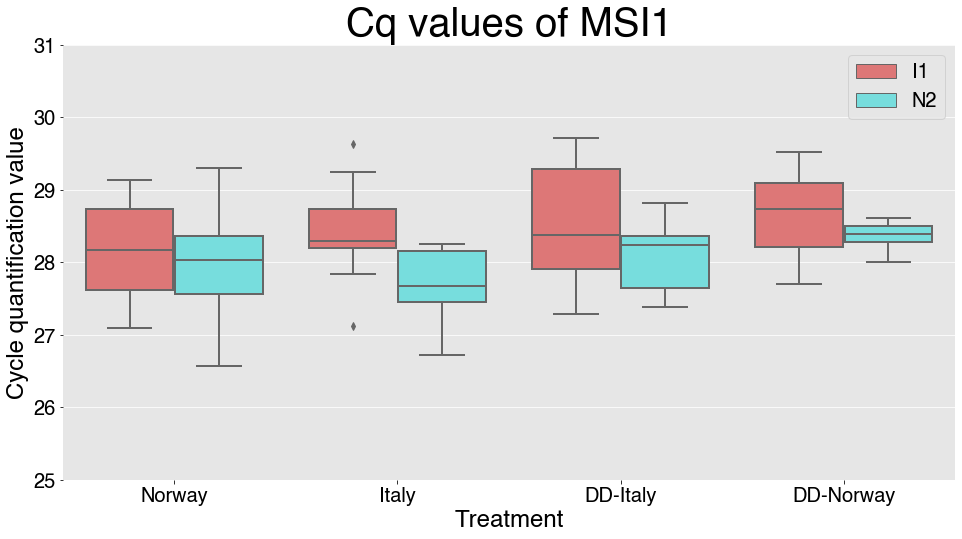

In [118]:
ax = sb.boxplot(x=(    'treatment',     ''), y = (    'MSI1', 'Mean'), hue = ('Clone',     ''), hue_order = ["I1", "N2"],
             data = ref_genes)

ax.set_ylim(25,31)
pp.xlabel("Treatment")
pp.ylabel("Cycle quantification value")
pp.title("Cq values of MSI1")
pp.legend()

pp.savefig("AVG_Cq_MSI1", dpi=300)
pp.show()

### Statistics <a class="anchor" id="stats_M"></a>

### N2

In [119]:
# Ordinary Least Squares (OLS) model
N2_MSI1_model = ols(formula = "Q('MSI1 Mean')"+" ~ "+"C(treatment)", data=N2_ref).fit()
N2_MSI1_anova_table = sm.stats.anova_lm(N2_MSI1_model, typ=2)
N2_MSI1_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),1.966243,3.0,1.970469,0.136952
Residual,11.309031,34.0,NaN,NaN


In [120]:
# Assumption Check - Normality 
stats.shapiro(N2_MSI1_model.resid)

(0.9793035984039307, 0.6928209662437439)

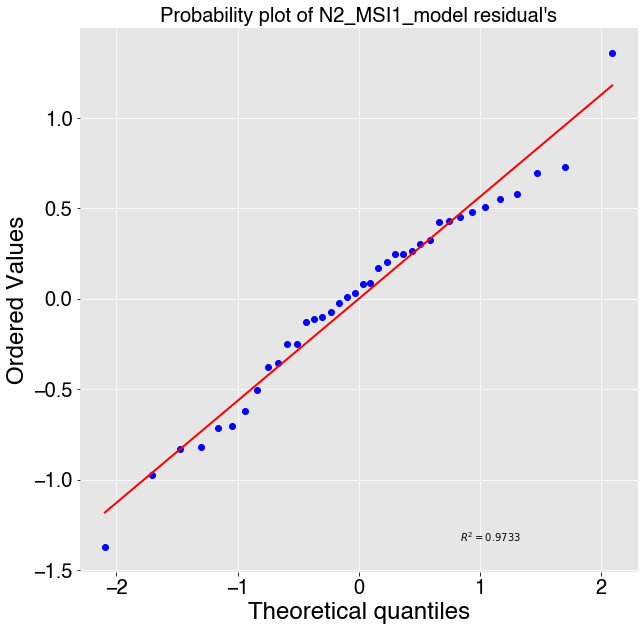

In [121]:
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(N2_MSI1_model.resid, plot= pp, rvalue= True)
ax.set_title("Probability plot of N2_MSI1_model residual's", fontsize= 20)
ax.set

pp.show()

### I1

In [122]:
# Ordinary Least Squares (OLS) model
I1_MSI1_model = ols(formula = "Q('MSI1 Mean')"+" ~ "+"C(treatment)", data=I1_ref).fit()
I1_MSI1_anova_table = sm.stats.anova_lm(I1_MSI1_model, typ=2)
I1_MSI1_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),1.002301,3.0,0.680909,0.569838
Residual,16.682715,34.0,NaN,NaN


In [123]:
# Assumption Check - Normality 
stats.shapiro(I1_MSI1_model.resid)

(0.9790924787521362, 0.6852998733520508)

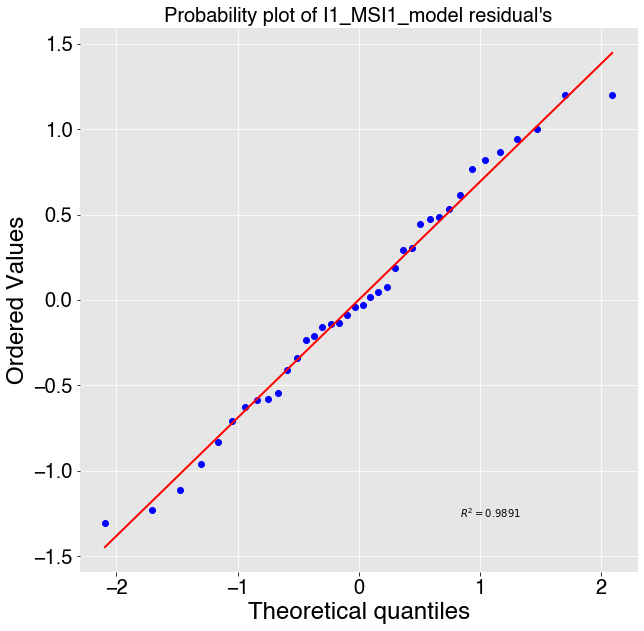

In [124]:
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(I1_MSI1_model.resid, plot= pp, rvalue= True)
ax.set_title("Probability plot of I1_MSI1_model residual's", fontsize= 20)
ax.set

pp.show()

## GAPDH <a class="anchor" id="treat_G"></a>

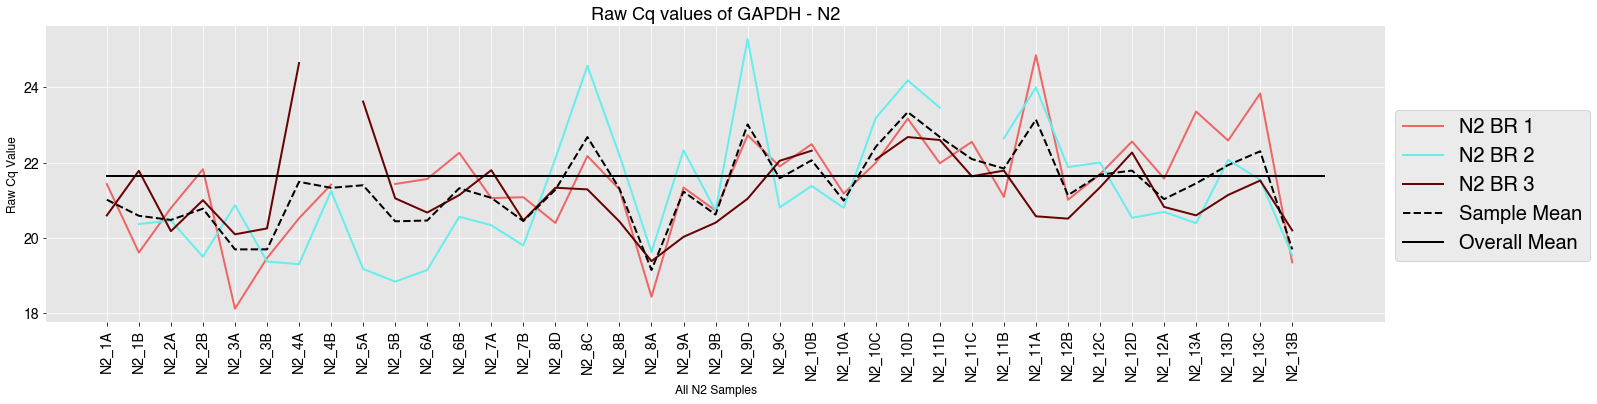

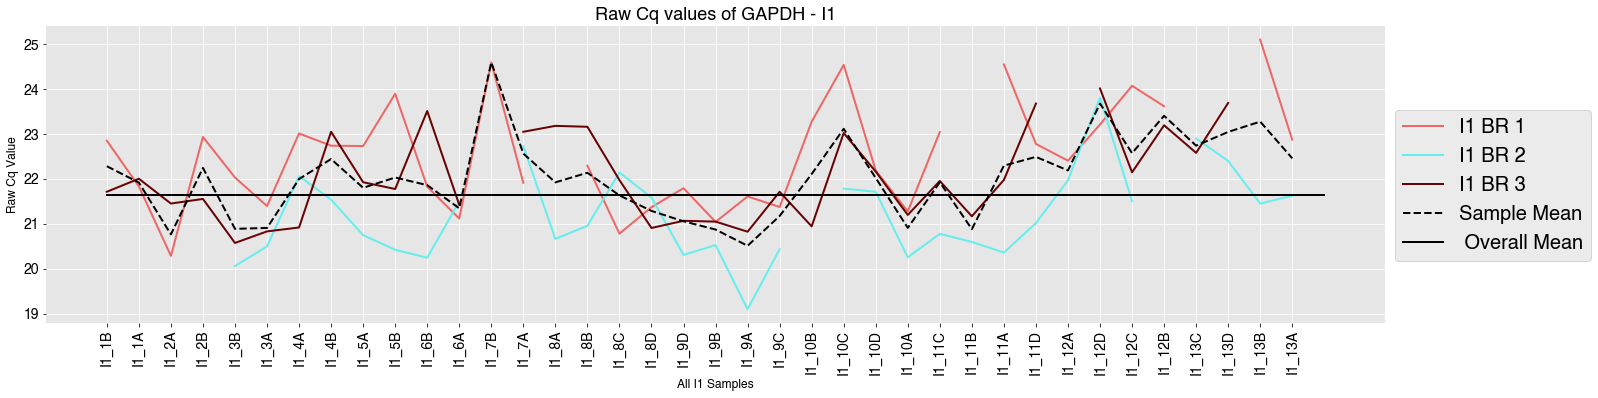

In [125]:
fig = pp.figure(figsize=(24,12))

I1_q = ref_genes.loc[ref_genes[(   'Clone',     '')] == "I1"]
N2_q = ref_genes.loc[ref_genes[(   'Clone',     '')] == "N2"]

pp.subplot(2, 1, 1) # n_rows, n_columns, current plot
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'GAPDH', 'Cq_1')], label = "N2 BR 1")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'GAPDH', 'Cq_2')], label = "N2 BR 2")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'GAPDH', 'Cq_3')], label = "N2 BR 3")
pp.plot(N2_q[(   'Sample',     '')], N2_q[(    'GAPDH', 'Mean')], color = "black", linestyle = "dashed", label = "Sample Mean")
pp.plot([0,38], [21.64,21.64], color = "black", label = "Overall Mean")


pp.xlabel("All N2 Samples", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.ylabel("Raw Cq Value", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.xticks(N2_q[(   'Sample',     '')], fontsize=14, rotation=90)
pp.yticks(fontsize=14)
pp.title("Raw Cq values of GAPDH - N2", fontdict = {'fontweight' : 'bold', 'fontsize' : 18})
pp.legend(bbox_to_anchor=(1,0.75))



fig = pp.figure(figsize=(24,12))
pp.subplot(2, 1, 2)
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'GAPDH', 'Cq_1')], label = "I1 BR 1")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'GAPDH', 'Cq_2')], label = "I1 BR 2")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'GAPDH', 'Cq_3')], label = "I1 BR 3")
pp.plot(I1_q[(   'Sample',     '')], I1_q[(    'GAPDH', 'Mean')], color = "black", linestyle = "dashed", label = "Sample Mean")
pp.plot([0,38], [21.64, 21.64], color = "black", label = " Overall Mean")

pp.xlabel("All I1 Samples", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.ylabel("Raw Cq Value", fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
pp.xticks(I1_q[(   'Sample',     '')], fontsize=14, rotation=90)
pp.yticks(fontsize=14)
pp.title("Raw Cq values of GAPDH - I1", fontdict = {'fontweight' : 'bold', 'fontsize' : 18})
pp.legend(bbox_to_anchor=(1,0.75))

pp.show()

### Plot <a class="anchor" id="plot_G"></a>

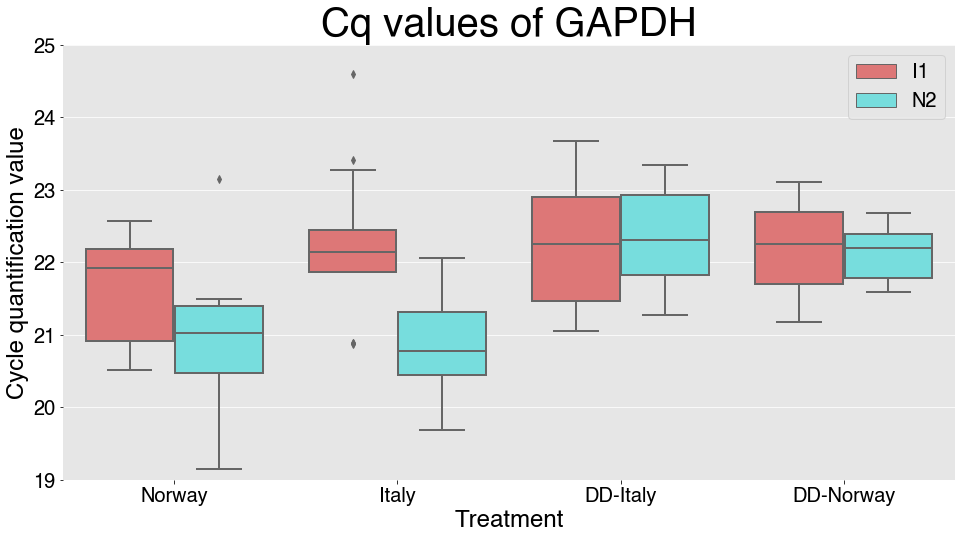

In [126]:
ax = sb.boxplot(x=(    'treatment',     ''), y = (    'GAPDH', 'Mean'), hue = ('Clone',     ''), hue_order = ["I1", "N2"],
             data = ref_genes)

ax.set_ylim(19, 25)
pp.xlabel("Treatment")
pp.ylabel("Cycle quantification value")
pp.title("Cq values of GAPDH")
pp.legend()

pp.savefig("AVG_Cq_GAPDH", dpi=300)
pp.show()

### Statistics <a class="anchor" id="stats_G"></a>

### N2

In [127]:
rp.summary_cont(N2_ref['GAPDH Mean'].groupby(N2_ref["treatment"]))

,N,Mean,SD,SE,95% Conf.,Interval
treatment,,,,,,
DD-Italy,6,22.340962,0.797798,0.325700,21.641661,23.040262
DD-Norway,6,22.126944,0.428321,0.174861,21.751504,22.502383
Italy,13,20.865027,0.726250,0.201425,20.454112,21.275941
Norway,13,20.967248,0.955529,0.265016,20.426607,21.507890


In [128]:
# Ordinary Least Squares (OLS) model
N2_GAPDH_model = ols(formula = "Q('GAPDH Mean')"+" ~ "+"C(treatment)", data=N2_ref).fit()
N2_GAPDH_anova_table = sm.stats.anova_lm(N2_GAPDH_model, typ=2)
N2_GAPDH_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),14.464038,3.0,7.665312,0.000482
Residual,21.385401,34.0,NaN,NaN


In [129]:
# Post-Hoc Testing for OLS
# Tukey Honestly Significant Difference (HSD)
N2_GAPDH_treat_comp = pairwise_tukeyhsd(endog=N2_ref['GAPDH Mean'], groups=N2_ref['treatment'], alpha=0.05)
print(N2_GAPDH_treat_comp)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 DD-Italy DD-Norway   -0.214    0.9 -1.4507  1.0226  False
 DD-Italy     Italy  -1.4759 0.0033 -2.5331 -0.4188   True
 DD-Italy    Norway  -1.3737 0.0067 -2.4309 -0.3166   True
DD-Norway     Italy  -1.2619 0.0141 -2.3191 -0.2048   True
DD-Norway    Norway  -1.1597  0.027 -2.2168 -0.1025   True
    Italy    Norway   0.1022    0.9 -0.7379  0.9424  False
----------------------------------------------------------


In N2, GAPDH is significantly different between Italy and DD-Italy treatments (p=0.003), Norway and DD-Italy treatments (p=0.006), Italy and DD-Norway treatments (p=0.01) and Norway and DD-Norway (p=0.02). 

In [130]:
# Assumption Check - Normality 
stats.shapiro(N2_GAPDH_model.resid)

(0.9723989963531494, 0.46012887358665466)

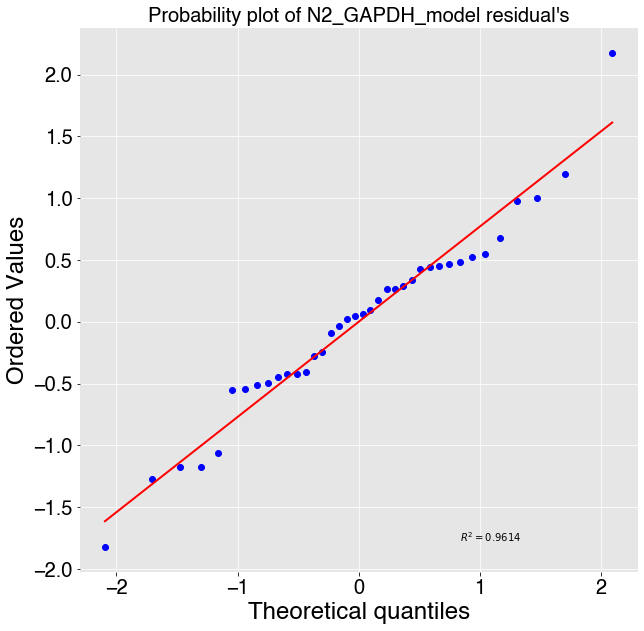

In [131]:
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(N2_GAPDH_model.resid, plot= pp, rvalue= True)
ax.set_title("Probability plot of N2_GAPDH_model residual's", fontsize= 20)
ax.set

pp.show()

In [132]:
# Assumption check - Homogeneity of variance
stats.levene(N2_ref['GAPDH Mean'][N2_ref['treatment'] == "Norway"],
                        N2_ref['GAPDH Mean'][N2_ref['treatment'] == "Italy"],
                        N2_ref['GAPDH Mean'][N2_ref['treatment'] == "DD-Norway"],
                        N2_ref['GAPDH Mean'][N2_ref['treatment'] == "DD-Italy"])

LeveneResult(statistic=0.5210544309768408, pvalue=0.6706846513763629)

### I1

In [133]:
# Ordinary Least Squares (OLS) model
I1_GAPDH_model = ols(formula = "Q('GAPDH Mean')"+" ~ "+"C(treatment)", data=I1_ref).fit()
I1_GAPDH_anova_table = sm.stats.anova_lm(I1_GAPDH_model, typ=2)
I1_GAPDH_anova_table

,sum_sq,df,F,PR(>F)
C(treatment),2.792255,3.0,1.157333,0.340256
Residual,27.343512,34.0,NaN,NaN


In I1, GAPDH is not significantly different between treatments.

In [134]:
# Assumption Check - Normality 
stats.shapiro(I1_GAPDH_model.resid)

(0.9713667035102844, 0.42969778180122375)

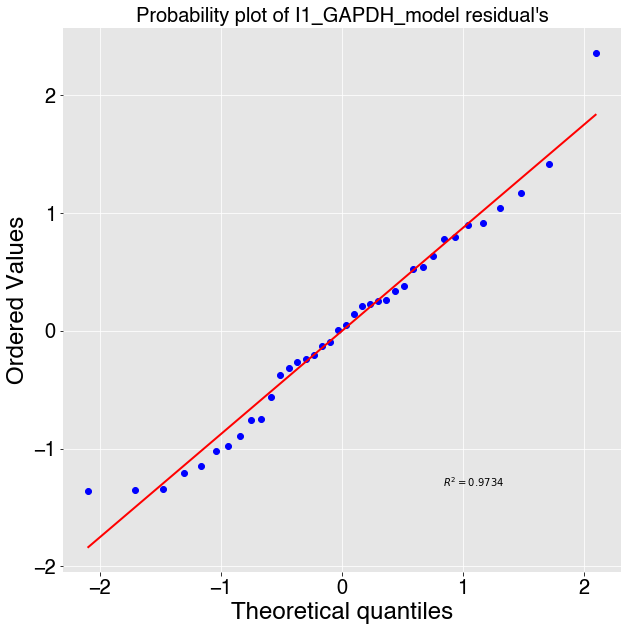

In [135]:
fig = pp.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(I1_GAPDH_model.resid, plot= pp, rvalue= True)
ax.set_title("Probability plot of I1_GAPDH_model residual's", fontsize= 20)
ax.set

pp.show()

p=0.42 and R^2 = 0.97. Residuals are normally distributed. 

In [136]:
# Assumption check - Homogeneity of variance
stats.levene(I1_ref['GAPDH Mean'][I1_ref['treatment'] == "Norway"],
                        I1_ref['GAPDH Mean'][I1_ref['treatment'] == "Italy"],
                        I1_ref['GAPDH Mean'][I1_ref['treatment'] == "DD-Norway"],
                        I1_ref['GAPDH Mean'][I1_ref['treatment'] == "DD-Italy"])

LeveneResult(statistic=0.3789407896437645, pvalue=0.7687694182000552)

## Comments <a class="anchor" id="ref_comments"></a>

MSI1 is not significantly different between treatments in either clone. GAPDH is not significantly different between treatments in I1, but in N2, GAPDH is significantly different between Italy and DD-Italy treatments (p=0.001), Norway and DD-Italy treatments (p=0.001), and Italy and DD-Italy treatments (p=0.04). 

# Target Genes <a class="anchor" id="target_genes"></a>

In [137]:
raw_merge.head()

Target                                GAPDH                               LHY  \
Cq                                     Cq_1       Cq_2       Cq_3 2-deltaCq_1   
Clone Sample treatment zeitgeber                                                
N2    N2_1A  Norway    0          21.430556        NaN  20.595556   27.648925   
      N2_1B  Italy     0          19.607571  20.368138  21.782572   16.809348   
I1    I1_1B  Italy     0          22.852806        NaN  21.715142   94.828634   
      I1_1A  Norway    0          21.834811        NaN  22.004871   56.107602   
N2    N2_2A  Norway    4          20.792569  20.458024  20.176330   52.790793   

Target                                                               \
Cq                               2-deltaCq_2 2-deltaCq_3       Cq_1   
Clone Sample treatment zeitgeber                                      
N2    N2_1A  Norway    0                 NaN   17.750799  23.972973   
      N2_1B  Italy     0           92.220509  162.399536  22.410477   
I1    I1_1B  Italy     0                 NaN  177.701224  22.353653   
      I1_1A  Norway    0                 NaN   55.565902  21.915832   
N2    N2_2A  Norway    4           60.278318   53.215901  22.608713   

Target                                                            ...  \
Cq                                     Cq_2       Cq_3 deltaCq_1  ...   
Clone Sample treatment zeitgeber                                  ...   
N2    N2_1A  Norway    0                NaN  23.616705 -4.789152  ...   
      N2_1B  Italy     0          22.004851  22.178908 -4.071192  ...   
I1    I1_1B  Italy     0                NaN  21.076841 -6.567251  ...   
      I1_1A  Norway    0                NaN  22.825598 -5.810124  ...   
N2    N2_2A  Norway    4          23.041714  22.088794 -5.722214  ...   

Target                                RVE8        TOC1              \
Cq                               deltaCq_3 2-deltaCq_1 2-deltaCq_2   
Clone Sample treatment zeitgeber                                     
N2    N2_1A  Norway    0         -1.918252    0.180619         NaN   
      N2_1B  Italy     0         -3.991556    0.419355    0.487285   
I1    I1_1B  Italy     0         -4.450332    0.492111         NaN   
      I1_1A  Norway    0         -3.374831    0.668632         NaN   
N2    N2_2A  Norway    4         -3.309130    0.293198    0.579876   

Target                                                                         \
Cq                               2-deltaCq_3       Cq_1       Cq_2       Cq_3   
Clone Sample treatment zeitgeber                                                
N2    N2_1A  Norway    0            1.743919  31.231103        NaN  26.964184   
      N2_1B  Italy     0            0.999420  27.735426  29.569029  29.523149   
I1    I1_1B  Italy     0            1.119575  29.943847        NaN  28.387199   
      I1_1A  Norway    0            1.620233  28.306672        NaN  27.925525   
N2    N2_2A  Norway    4            1.198012  30.100982  29.741464  27.561937   

Target                                                          
Cq                               deltaCq_1 deltaCq_2 deltaCq_3  
Clone Sample treatment zeitgeber                                
N2    N2_1A  Norway    0          2.468979       NaN -0.802333  
      N2_1B  Italy     0          1.253757  1.037162  0.000837  
I1    I1_1B  Italy     0          1.022944       NaN -0.162952  
      I1_1A  Norway    0          0.580716       NaN -0.696201  
N2    N2_2A  Norway    4          1.770054  0.786183 -0.260643  

[5 rows x 78 columns]

In [138]:
raw_merge.drop(columns = ["GAPDH", "MSI1"], level = 0, inplace = True)
raw_merge.drop(columns = ['Cq_1', 'Cq_2', 'Cq_3'], level = 1, inplace = True)

In [139]:
raw_merge = raw_merge.stack(level=0)
raw_merge["Avg_2-deltaCq"] = None
raw_merge["Std_2-deltaCq"] = None
raw_merge = raw_merge.unstack().swaplevel(0,1,axis = 1).sort_index(axis=1)

In [140]:
# Make Avg_2-deltaCq columns equal to the Avg of all 3 biological replicates.
raw_merge[('LHY', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'LHY',   '2-deltaCq_1')], raw_merge[(  'LHY',   '2-deltaCq_2')], raw_merge[(  'LHY',   '2-deltaCq_3')]), axis = 0)
raw_merge[('LUX', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'LUX',   '2-deltaCq_1')], raw_merge[(  'LUX',   '2-deltaCq_2')], raw_merge[(  'LUX',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRDX', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'PRDX',   '2-deltaCq_1')], raw_merge[(  'PRDX',   '2-deltaCq_2')], raw_merge[(  'PRDX',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR9', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'PRR9',   '2-deltaCq_1')], raw_merge[(  'PRR9',   '2-deltaCq_2')], raw_merge[(  'PRR9',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR7', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'PRR7',   '2-deltaCq_1')], raw_merge[(  'PRR7',   '2-deltaCq_2')], raw_merge[(  'PRR7',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR5', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'PRR5',   '2-deltaCq_1')], raw_merge[(  'PRR5',   '2-deltaCq_2')], raw_merge[(  'PRR5',   '2-deltaCq_3')]), axis = 0)
raw_merge[('RVE8', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'RVE8',   '2-deltaCq_1')], raw_merge[(  'RVE8',   '2-deltaCq_2')], raw_merge[(  'RVE8',   '2-deltaCq_3')]), axis = 0)
raw_merge[('TOC1', 'Avg_2-deltaCq')] = np.nanmean((raw_merge[(  'TOC1',   '2-deltaCq_1')], raw_merge[(  'TOC1',   '2-deltaCq_2')], raw_merge[(  'TOC1',   '2-deltaCq_3')]), axis = 0)



In [141]:
#Standard deviation values for 2-deltaCq of 3 biological replicates
raw_merge[('LHY', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'LHY',   '2-deltaCq_1')], raw_merge[(  'LHY',   '2-deltaCq_2')], raw_merge[(  'LHY',   '2-deltaCq_3')]), axis = 0)
raw_merge[('LUX', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'LUX',   '2-deltaCq_1')], raw_merge[(  'LUX',   '2-deltaCq_2')], raw_merge[(  'LUX',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRDX', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'PRDX',   '2-deltaCq_1')], raw_merge[(  'PRDX',   '2-deltaCq_2')], raw_merge[(  'PRDX',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR9', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'PRR9',   '2-deltaCq_1')], raw_merge[(  'PRR9',   '2-deltaCq_2')], raw_merge[(  'PRR9',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR7', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'PRR7',   '2-deltaCq_1')], raw_merge[(  'PRR7',   '2-deltaCq_2')], raw_merge[(  'PRR7',   '2-deltaCq_3')]), axis = 0)
raw_merge[('PRR5', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'PRR5',   '2-deltaCq_1')], raw_merge[(  'PRR5',   '2-deltaCq_2')], raw_merge[(  'PRR5',   '2-deltaCq_3')]), axis = 0)
raw_merge[('RVE8', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'RVE8',   '2-deltaCq_1')], raw_merge[(  'RVE8',   '2-deltaCq_2')], raw_merge[(  'RVE8',   '2-deltaCq_3')]), axis = 0)
raw_merge[('TOC1', 'Std_2-deltaCq')] = np.nanstd((raw_merge[(  'TOC1',   '2-deltaCq_1')], raw_merge[(  'TOC1',   '2-deltaCq_2')], raw_merge[(  'TOC1',   '2-deltaCq_3')]), axis = 0)


In [142]:
raw_merge.sort_values("zeitgeber", inplace = True)
raw_merge.head()

Target                                   LHY                          \
Cq                               2-deltaCq_1 2-deltaCq_2 2-deltaCq_3   
Clone Sample treatment zeitgeber                                       
N2    N2_1A  Norway    0           27.648925         NaN   17.750799   
      N2_1B  Italy     0           16.809348   92.220509  162.399536   
I1    I1_1B  Italy     0           94.828634         NaN  177.701224   
      I1_1A  Norway    0           56.107602         NaN   55.565902   
N2    N2_2A  Norway    4           52.790793   60.278318   53.215901   

Target                                                                  \
Cq                               Avg_2-deltaCq Std_2-deltaCq deltaCq_1   
Clone Sample treatment zeitgeber                                         
N2    N2_1A  Norway    0             22.699862      4.949063 -4.789152   
      N2_1B  Italy     0             90.476464     59.449738 -4.071192   
I1    I1_1B  Italy     0            136.264929     41.436295 -6.567251   
      I1_1A  Norway    0             55.836752      0.270850 -5.810124   
N2    N2_2A  Norway    4             55.428337      3.433843 -5.722214   

Target                                                       LUX              \
Cq                               deltaCq_2 deltaCq_3 2-deltaCq_1 2-deltaCq_2   
Clone Sample treatment zeitgeber                                               
N2    N2_1A  Norway    0               NaN -4.149812    0.051209         NaN   
      N2_1B  Italy     0         -6.527016 -7.343404    0.055158    0.054210   
I1    I1_1B  Italy     0               NaN -7.473310    0.112392         NaN   
      I1_1A  Norway    0               NaN -5.796128    0.120483         NaN   
N2    N2_2A  Norway    4         -5.913567 -5.733785    0.065937    0.111012   

Target                            ...      RVE8                  TOC1  \
Cq                                ... deltaCq_2 deltaCq_3 2-deltaCq_1   
Clone Sample treatment zeitgeber  ...                                   
N2    N2_1A  Norway    0          ...       NaN -1.918252    0.180619   
      N2_1B  Italy     0          ... -2.478719 -3.991556    0.419355   
I1    I1_1B  Italy     0          ...       NaN -4.450332    0.492111   
      I1_1A  Norway    0          ...       NaN -3.374831    0.668632   
N2    N2_2A  Norway    4          ... -2.220014 -3.309130    0.293198   

Target                                                                  \
Cq                               2-deltaCq_2 2-deltaCq_3 Avg_2-deltaCq   
Clone Sample treatment zeitgeber                                         
N2    N2_1A  Norway    0                 NaN    1.743919      0.962269   
      N2_1B  Italy     0            0.487285    0.999420      0.635353   
I1    I1_1B  Italy     0                 NaN    1.119575      0.805843   
      I1_1A  Norway    0                 NaN    1.620233      1.144432   
N2    N2_2A  Norway    4            0.579876    1.198012      0.690362   

Target                                                                        
Cq                               Std_2-deltaCq deltaCq_1 deltaCq_2 deltaCq_3  
Clone Sample treatment zeitgeber                                              
N2    N2_1A  Norway    0              0.781650  2.468979       NaN -0.802333  
      N2_1B  Italy     0              0.258923  1.253757  1.037162  0.000837  
I1    I1_1B  Italy     0              0.313732  1.022944       NaN -0.162952  
      I1_1A  Norway    0              0.475800  0.580716       NaN -0.696201  
N2    N2_2A  Norway    4              0.377560  1.770054  0.786183 -0.260643  

[5 rows x 64 columns]

In [143]:
raw_merge.describe()

Target         LHY                                                      \
Cq     2-deltaCq_1 2-deltaCq_2 2-deltaCq_3 Avg_2-deltaCq Std_2-deltaCq   
count    71.000000   69.000000   71.000000     76.000000     76.000000   
mean     24.585268   32.682461   53.561521     37.643384     14.515894   
std      30.952142   43.390657   66.066817     44.368699     20.295943   
min       0.409659    0.649850    1.115613      0.878846      0.000000   
25%       2.932667    4.523372    7.468322      5.562194      1.479635   
50%       8.702730   12.863672   28.254666     16.821892      5.156571   
75%      27.707940   47.141295   76.765966     55.530441     17.519180   
max     124.178668  221.037635  292.521491    171.922580     91.226703   

Target                                          LUX              ...  \
Cq      deltaCq_1  deltaCq_2  deltaCq_3 2-deltaCq_1 2-deltaCq_2  ...   
count   71.000000  69.000000  71.000000   71.000000   68.000000  ...   
mean    -3.259506  -3.744653  -4.514435    0.375431    0.492965  ...   
std      2.242602   2.089169   2.102115    0.381488    0.477227  ...   
min     -6.956274  -7.788148  -8.192399    0.008081    0.024974  ...   
25%     -4.792224  -5.558919  -6.261744    0.090479    0.136438  ...   
50%     -3.121468  -3.685231  -4.820417    0.267734    0.342104  ...   
75%     -1.552202  -2.177399  -2.900462    0.546416    0.669208  ...   
max      1.287503   0.621821  -0.157837    1.701424    2.368384  ...   

Target       RVE8                   TOC1                          \
Cq      deltaCq_2  deltaCq_3 2-deltaCq_1 2-deltaCq_2 2-deltaCq_3   
count   69.000000  69.000000   70.000000   69.000000   69.000000   
mean    -0.440425  -1.779811    0.819534    1.189592    1.595963   
std      2.009933   2.171353    0.499069    0.694216    0.758593   
min     -3.710640  -5.130636    0.063439    0.225253    0.470783   
25%     -2.220014  -3.559531    0.421944    0.679207    1.005955   
50%     -0.800288  -2.477505    0.786064    1.107855    1.612529   
75%      1.243085  -0.346065    1.102162    1.509441    2.049304   
max      3.729735   2.928324    2.023846    3.146556    3.276542   

Target                                                               
Cq     Avg_2-deltaCq Std_2-deltaCq  deltaCq_1  deltaCq_2  deltaCq_3  
count      76.000000     76.000000  70.000000  69.000000  69.000000  
mean        1.191760      0.392525   0.611823   0.018443  -0.490835  
std         0.561159      0.264458   1.070358   0.938175   0.770905  
min         0.207936      0.000000  -1.017099  -1.653773  -1.712174  
25%         0.757035      0.180904  -0.140304  -0.594014  -1.035134  
50%         1.119123      0.373615   0.347283  -0.147769  -0.689325  
75%         1.603598      0.499944   1.244893   0.558078  -0.008566  
max         2.485870      1.317715   3.978475   2.150384   1.086866  

[8 rows x 64 columns]

#### Clone and treatment groups for plotting

In [144]:
raw_merge.reset_index(inplace = True)
I1_A = raw_merge.loc[(raw_merge['Clone'] == "I1") & (raw_merge['treatment'] == 'Norway'), :]
I1_B = raw_merge.loc[(raw_merge['Clone'] == "I1") & (raw_merge['treatment'] == 'Italy'), :]
I1_C = raw_merge.loc[(raw_merge['Clone'] == "I1") & (raw_merge['treatment'] == 'DD-Norway'), :]
I1_D = raw_merge.loc[(raw_merge['Clone'] == "I1") & (raw_merge['treatment'] == 'DD-Italy'), :]

N2_A = raw_merge.loc[(raw_merge['Clone'] == "N2") & (raw_merge['treatment'] == 'Norway'), :]
N2_B = raw_merge.loc[(raw_merge['Clone'] == "N2") & (raw_merge['treatment'] == 'Italy'), :]
N2_C = raw_merge.loc[(raw_merge['Clone'] == "N2") & (raw_merge['treatment'] == 'DD-Norway'), :]
N2_D = raw_merge.loc[(raw_merge['Clone'] == "N2") & (raw_merge['treatment'] == 'DD-Italy'), :]

# LHY <a class="anchor" id="LHY"></a>

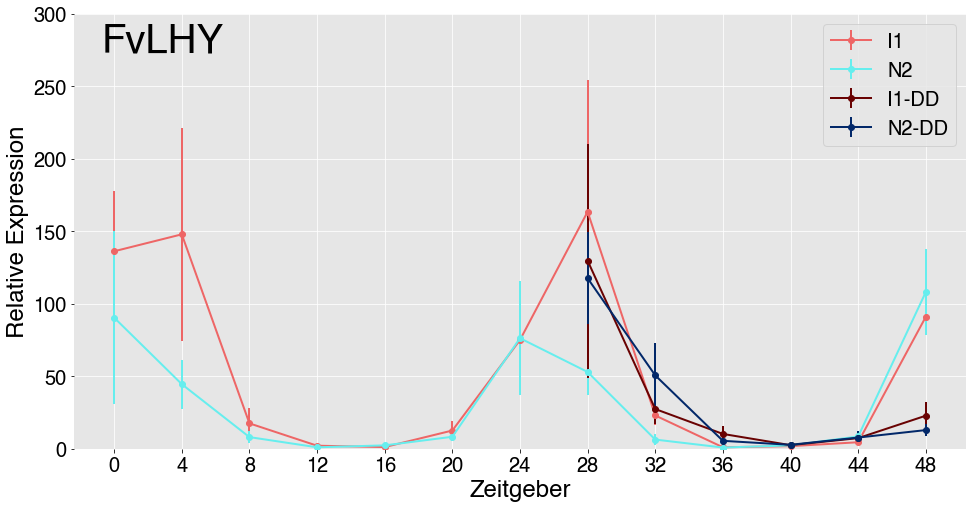

In [145]:
ax = pp.subplot()

ax.errorbar(I1_B["zeitgeber"], I1_B[('LHY', 'Avg_2-deltaCq')], yerr = I1_B[('LHY', 'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[('LHY', 'Avg_2-deltaCq')], yerr = N2_B[('LHY', 'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[('LHY', 'Avg_2-deltaCq')], yerr = I1_D[('LHY', 'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[('LHY', 'Avg_2-deltaCq')], yerr = N2_D[('LHY', 'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0, 300)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvLHY", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_B["zeitgeber"])

pp.savefig("2-deltaCq_LHY_Italy.png", dpi=300)
pp.show()

In [146]:
I1_B.loc[(I1_B["zeitgeber"] == 4) | (I1_B["zeitgeber"] == 28)]

Target Clone Sample treatment zeitgeber         LHY                          \
Cq                                      2-deltaCq_1 2-deltaCq_2 2-deltaCq_3   
7         I1  I1_2B     Italy         4   74.666057         NaN  221.232132   
32        I1  I1_8B     Italy        28  100.809202   97.241003  292.521491   

Target                                        ...      RVE8            \
Cq     Avg_2-deltaCq Std_2-deltaCq deltaCq_1  ... deltaCq_2 deltaCq_3   
7         147.949095     73.283037 -6.222381  ...       NaN -4.365378   
32        163.523898     91.226703 -6.655484  ... -3.104899 -5.130636   

Target        TOC1                                                      \
Cq     2-deltaCq_1 2-deltaCq_2 2-deltaCq_3 Avg_2-deltaCq Std_2-deltaCq   
7         0.197212         NaN    0.477614      0.337413      0.140201   
32        0.111712    0.225253    0.544737      0.293901      0.183325   

Target                                
Cq     deltaCq_1 deltaCq_2 deltaCq_3  
7       2.342181       NaN  1.066082  
32      3.162141  2.150384  0.876368  

[2 rows x 68 columns]

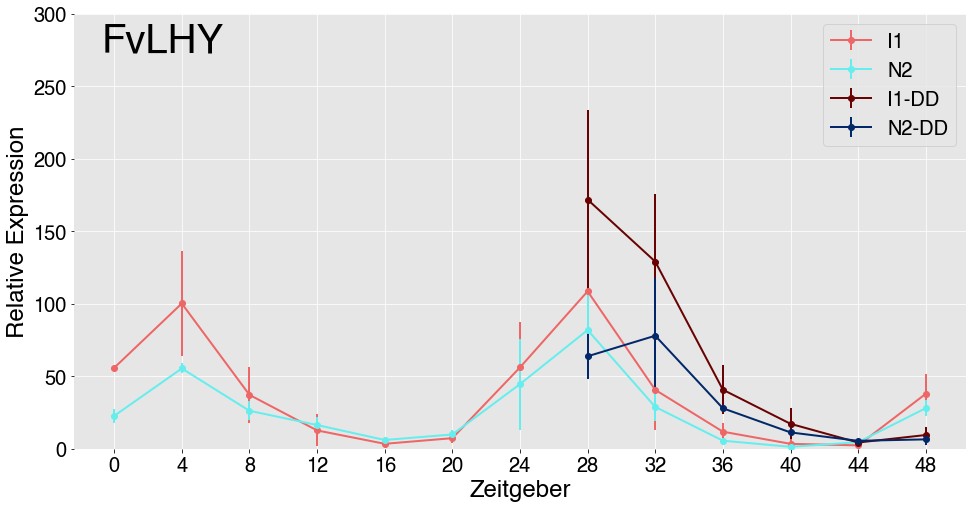

In [147]:
ax = pp.subplot()

ax.errorbar(I1_A["zeitgeber"], I1_A[(      'LHY',  'Avg_2-deltaCq')], yerr = I1_A[(      'LHY',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(      'LHY',  'Avg_2-deltaCq')], yerr = N2_A[(      'LHY',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(      'LHY',  'Avg_2-deltaCq')], yerr = I1_C[(      'LHY',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(      'LHY',  'Avg_2-deltaCq')], yerr = N2_C[(      'LHY',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0, 300)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvLHY", x=0.1, y=0.9)
pp.legend()

ax.set_xticks(I1_A["zeitgeber"])

pp.savefig("2-deltaCq_LHY_Norway.png", dpi=300)

pp.show()

# PRR9 <a class="anchor" id="PRR9"></a>

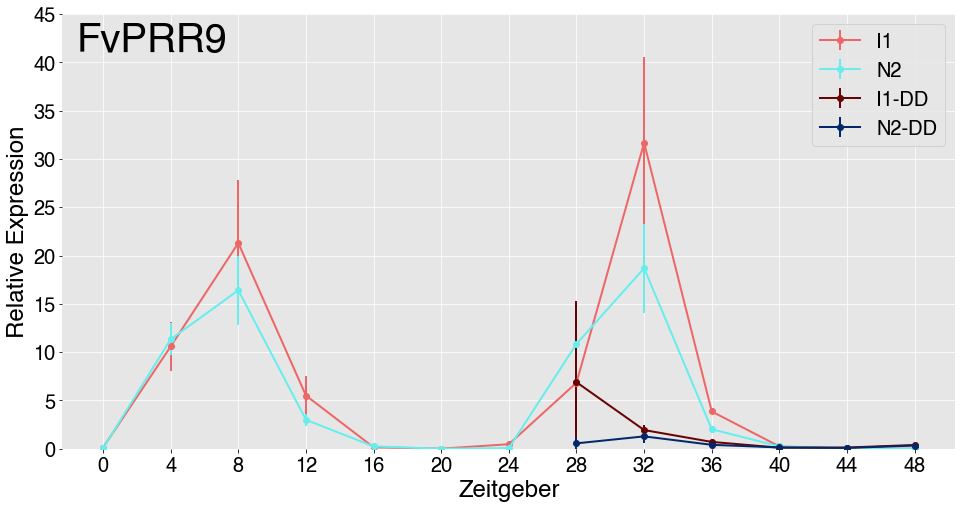

In [148]:
ax = pp.subplot()

ax.errorbar(I1_B["zeitgeber"], I1_B[(     'PRR9',  'Avg_2-deltaCq')], yerr = I1_B[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'PRR9',  'Avg_2-deltaCq')],  yerr = N2_B[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'PRR9',  'Avg_2-deltaCq')], yerr = I1_D[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'PRR9',  'Avg_2-deltaCq')],  yerr = N2_D[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,45)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR9", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR9_Italy.png", dpi=300)
pp.show()

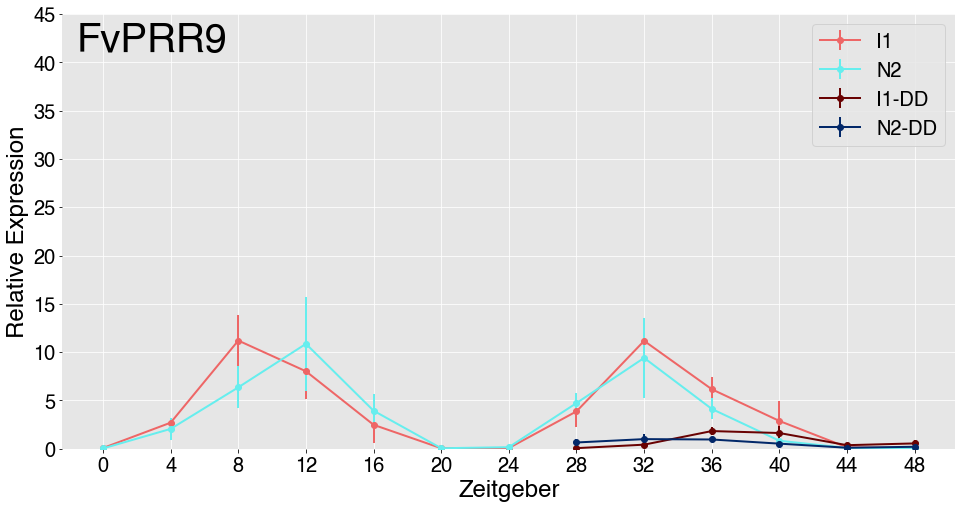

In [149]:
ax = pp.subplot()

ax.errorbar(I1_A["zeitgeber"], I1_A[(     'PRR9',  'Avg_2-deltaCq')], yerr = I1_A[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'PRR9',  'Avg_2-deltaCq')], yerr = N2_A[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o',  label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'PRR9',  'Avg_2-deltaCq')], yerr = I1_C[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'PRR9',  'Avg_2-deltaCq')], yerr = N2_C[(     'PRR9',  'Std_2-deltaCq')], fmt = '-o',  label = "N2-DD")

ax.set_ylim(0,45)


pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR9", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(I1_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR9_Norway.png", dpi=300)
pp.show()

# LUX <a class="anchor" id="LUX"></a>

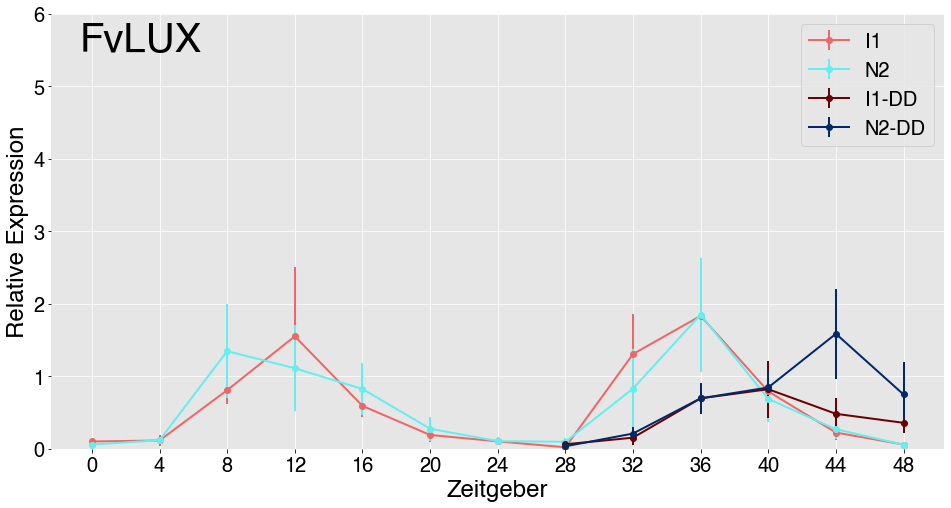

In [150]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(      'LUX',  'Avg_2-deltaCq')], yerr = I1_B[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(      'LUX',  'Avg_2-deltaCq')], yerr = N2_B[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(      'LUX',  'Avg_2-deltaCq')], yerr = I1_D[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(      'LUX',  'Avg_2-deltaCq')], yerr = N2_D[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,6)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvLUX", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_LUX_Italy.png", dpi=300)
pp.show()

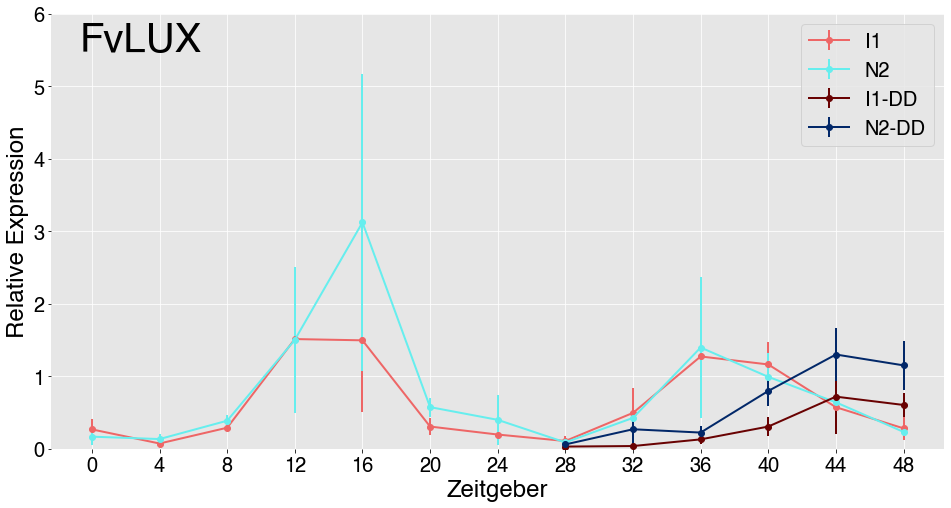

In [151]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(      'LUX',  'Avg_2-deltaCq')], yerr = I1_A[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(      'LUX',  'Avg_2-deltaCq')], yerr = N2_A[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(      'LUX',  'Avg_2-deltaCq')], yerr = I1_C[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(      'LUX',  'Avg_2-deltaCq')], yerr = N2_C[(      'LUX',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,6)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvLUX", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_LUX_Norway.png", dpi=300)
pp.show()

# PRDX <a class="anchor" id="PRDX"></a>

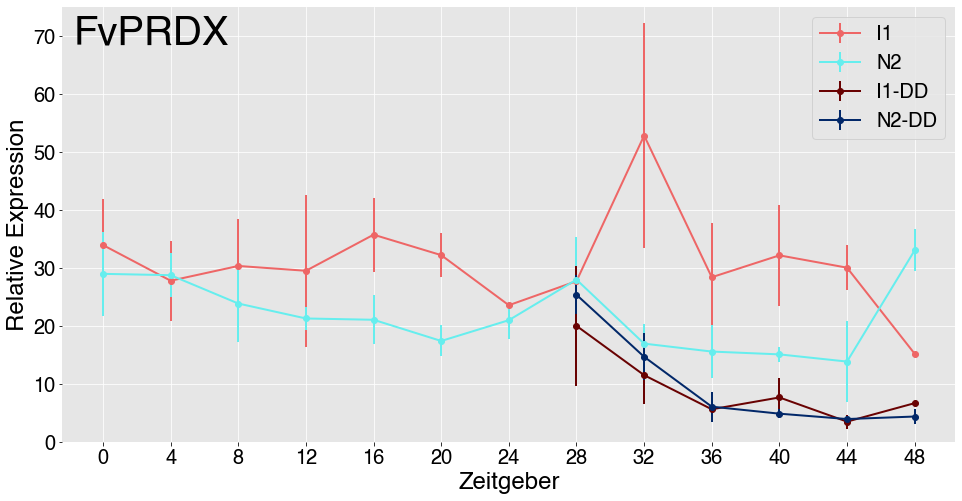

In [152]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(     'PRDX',  'Avg_2-deltaCq')], yerr = I1_B[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'PRDX',  'Avg_2-deltaCq')], yerr = N2_B[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'PRDX',  'Avg_2-deltaCq')], yerr = I1_D[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'PRDX',  'Avg_2-deltaCq')], yerr = N2_D[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,75)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRDX", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRDX_Italy.png", dpi=300)
pp.show()

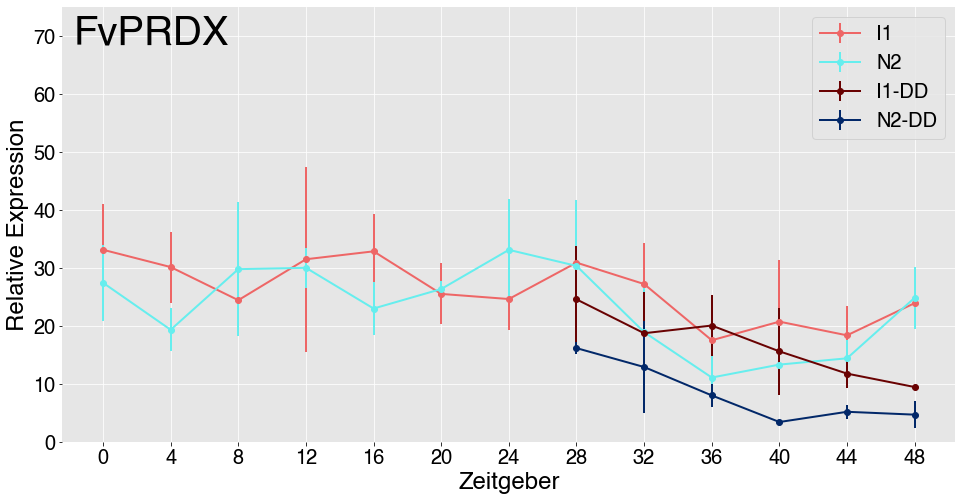

In [153]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(     'PRDX',  'Avg_2-deltaCq')], yerr = I1_A[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'PRDX',  'Avg_2-deltaCq')], yerr = N2_A[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'PRDX',  'Avg_2-deltaCq')], yerr = I1_C[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'PRDX',  'Avg_2-deltaCq')], yerr = N2_C[(     'PRDX',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,75)


pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRDX", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRDX_Norway.png", dpi=300)
pp.show()

# PRR7 <a class="anchor" id="PRR7"></a>

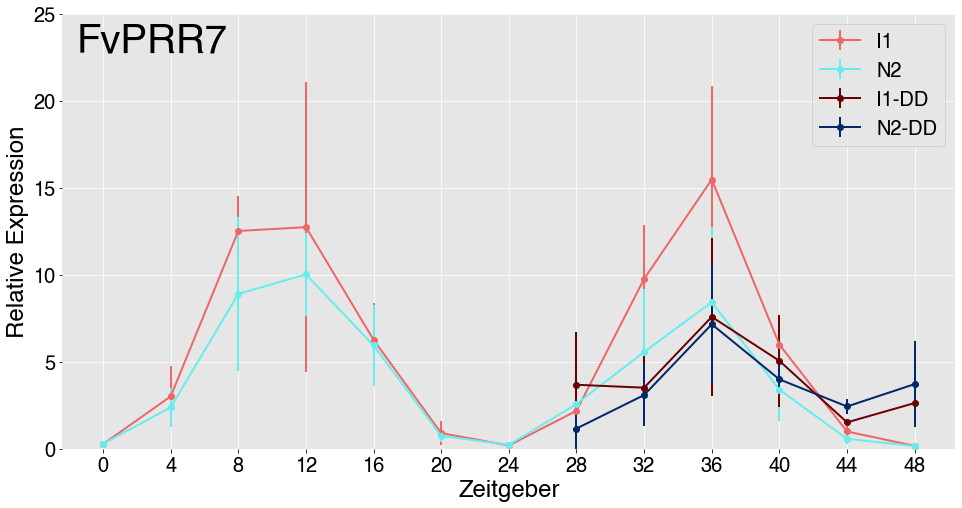

In [154]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(     'PRR7',  'Avg_2-deltaCq')], yerr = I1_B[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'PRR7',  'Avg_2-deltaCq')], yerr = N2_B[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'PRR7',  'Avg_2-deltaCq')], yerr = I1_D[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'PRR7',  'Avg_2-deltaCq')], yerr = N2_D[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,25)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR7", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR7_Italy.png", dpi=300)
pp.show()

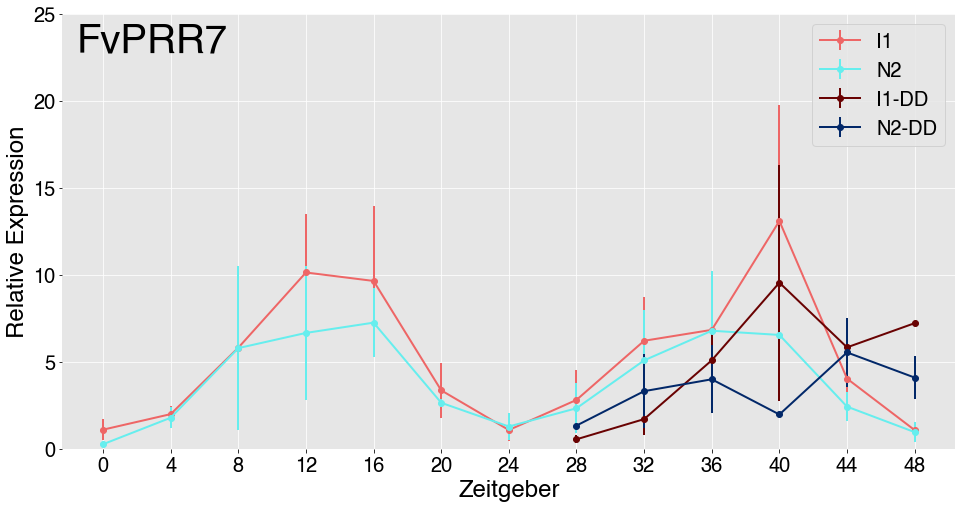

In [155]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(     'PRR7',  'Avg_2-deltaCq')], yerr = I1_A[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'PRR7',  'Avg_2-deltaCq')], yerr = N2_A[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'PRR7',  'Avg_2-deltaCq')], yerr = I1_C[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'PRR7',  'Avg_2-deltaCq')], yerr = N2_C[(     'PRR7',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,25)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR7", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR7_Norway.png", dpi=300)
pp.show()

# PRR5 <a class="anchor" id="PRR5"></a>

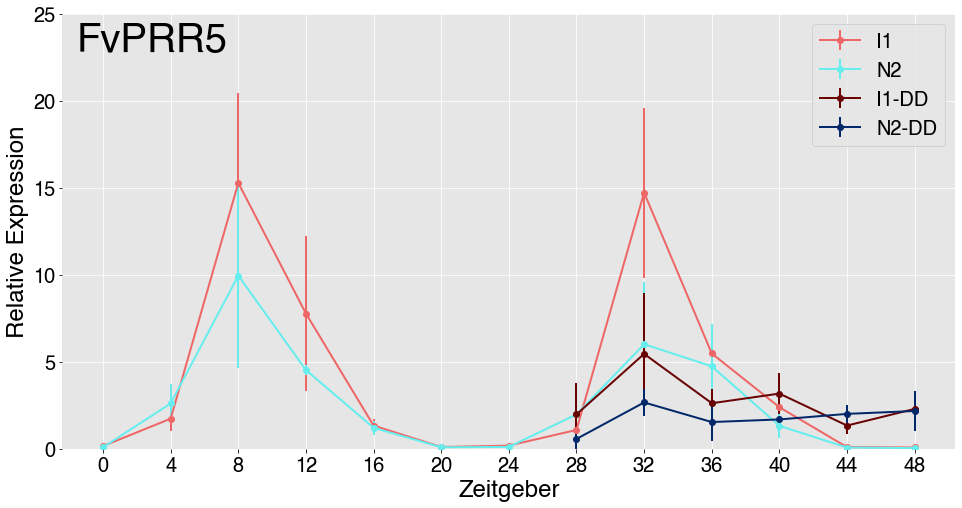

In [156]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(     'PRR5',  'Avg_2-deltaCq')], yerr = I1_B[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'PRR5',  'Avg_2-deltaCq')], yerr = N2_B[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'PRR5',  'Avg_2-deltaCq')], yerr = I1_D[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'PRR5',  'Avg_2-deltaCq')], yerr = N2_D[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,25)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR5", x=0.1, y=0.9)
pp.legend()

ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR5_Italy.png", dpi=300)
pp.show()

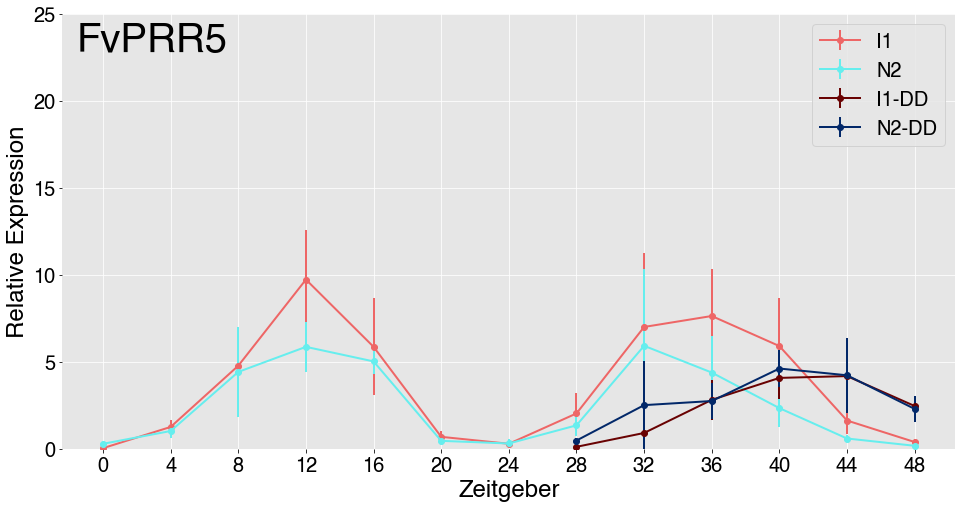

In [157]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(     'PRR5',  'Avg_2-deltaCq')], yerr = I1_A[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'PRR5',  'Avg_2-deltaCq')], yerr = N2_A[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'PRR5',  'Avg_2-deltaCq')], yerr = I1_C[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'PRR5',  'Avg_2-deltaCq')], yerr = N2_C[(     'PRR5',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,25)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvPRR5", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_PRR5_Norway.png", dpi=300)
pp.show()

# RVE8 <a class="anchor" id="RVE8"></a>

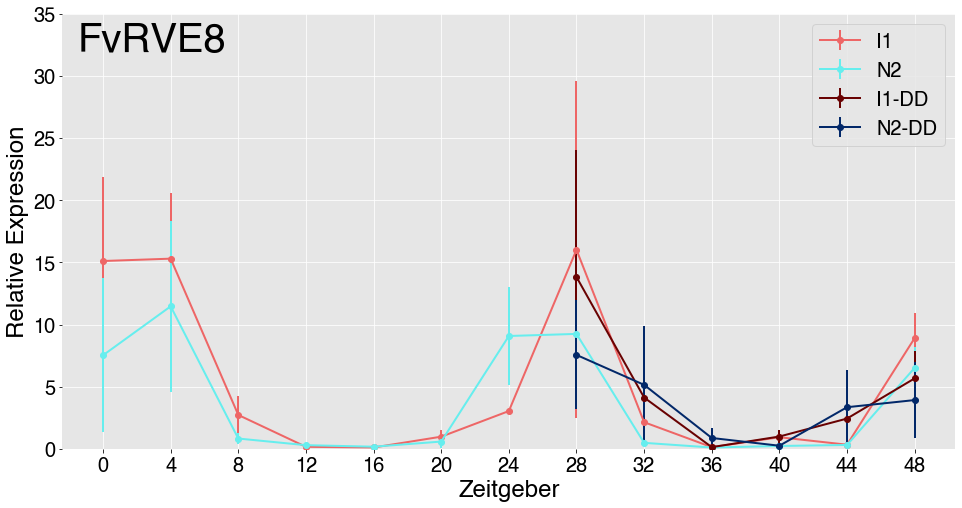

In [158]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(     'RVE8',  'Avg_2-deltaCq')], yerr = I1_B[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'RVE8',  'Avg_2-deltaCq')], yerr = N2_B[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'RVE8',  'Avg_2-deltaCq')], yerr = I1_D[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'RVE8',  'Avg_2-deltaCq')], yerr = N2_D[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,35)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvRVE8", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_RVE8_Italy.png", dpi=300)
pp.show()

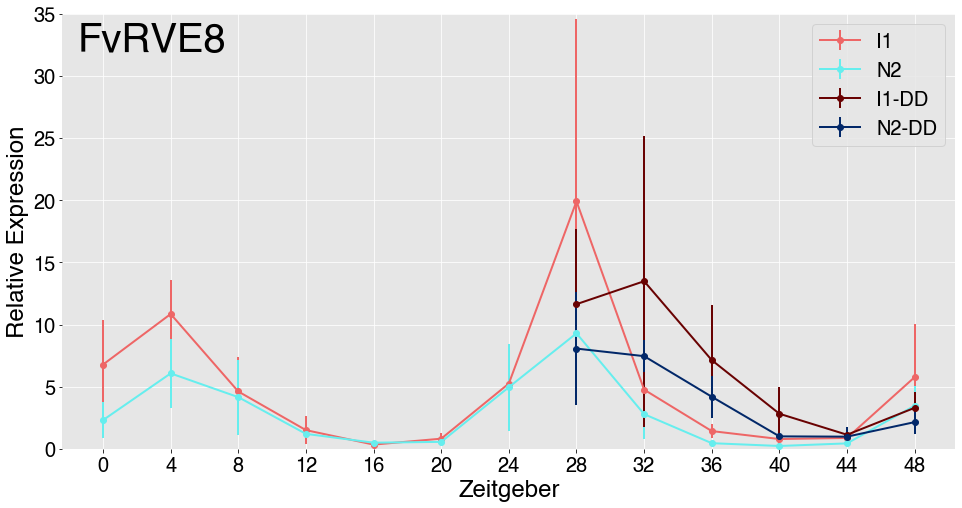

In [159]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(     'RVE8',  'Avg_2-deltaCq')], yerr = I1_A[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'RVE8',  'Avg_2-deltaCq')], yerr = N2_A[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'RVE8',  'Avg_2-deltaCq')], yerr = I1_C[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'RVE8',  'Avg_2-deltaCq')], yerr = N2_C[(     'RVE8',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,35)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvRVE8", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_RVE8_Norway.png", dpi=300)
pp.show()

# TOC1 <a class="anchor" id="TOC1"></a>

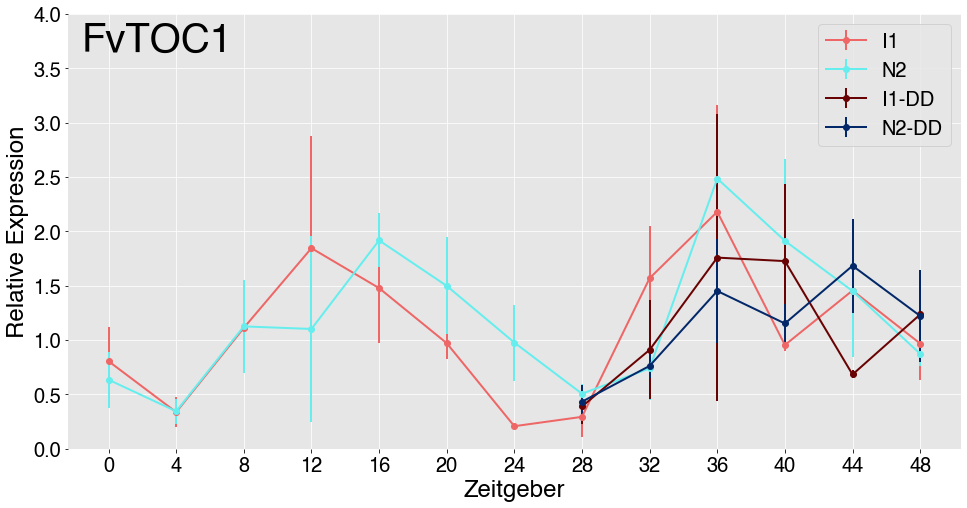

In [160]:
ax = pp.subplot()
ax.errorbar(I1_B["zeitgeber"], I1_B[(     'TOC1',  'Avg_2-deltaCq')], yerr = I1_B[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_B["zeitgeber"], N2_B[(     'TOC1',  'Avg_2-deltaCq')], yerr = N2_B[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_D["zeitgeber"], I1_D[(     'TOC1',  'Avg_2-deltaCq')], yerr = I1_D[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_D["zeitgeber"], N2_D[(     'TOC1',  'Avg_2-deltaCq')], yerr = N2_D[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,4)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvTOC1", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_TOC1_Italy.png", dpi=300)
pp.show()

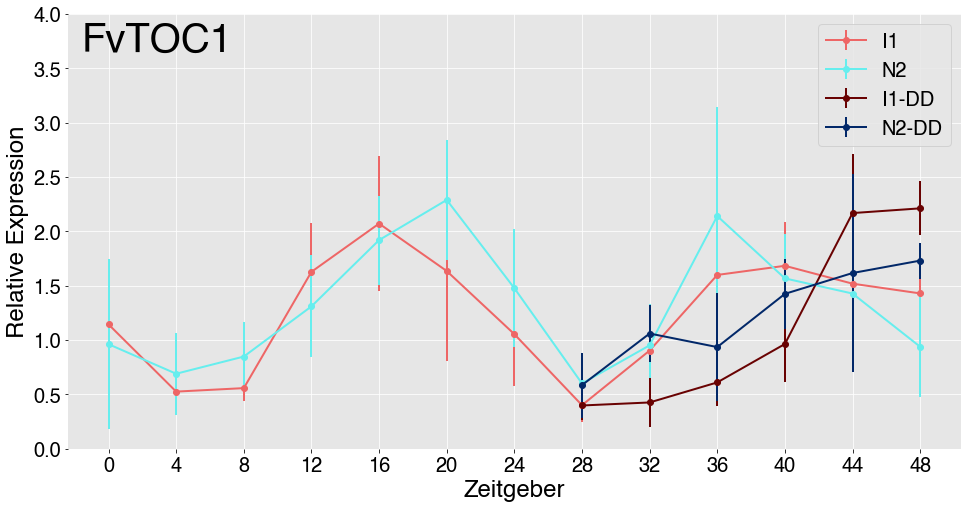

In [161]:
ax = pp.subplot()
ax.errorbar(I1_A["zeitgeber"], I1_A[(     'TOC1',  'Avg_2-deltaCq')], yerr = I1_A[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "I1")
ax.errorbar(N2_A["zeitgeber"], N2_A[(     'TOC1',  'Avg_2-deltaCq')], yerr = N2_A[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "N2")

ax.errorbar(I1_C["zeitgeber"], I1_C[(     'TOC1',  'Avg_2-deltaCq')], yerr = I1_C[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "I1-DD")
ax.errorbar(N2_C["zeitgeber"], N2_C[(     'TOC1',  'Avg_2-deltaCq')], yerr = N2_C[(     'TOC1',  'Std_2-deltaCq')], fmt = '-o', label = "N2-DD")

ax.set_ylim(0,4)

pp.xlabel("Zeitgeber")
pp.ylabel("Relative Expression")
pp.title(label = "FvTOC1", x=0.1, y=0.9)
pp.legend()
ax.set_xticks(N2_A["zeitgeber"])

pp.savefig("2-deltaCq_TOC1_Norway.png", dpi=300)
pp.show()

# Target Gene Statistics <a class="anchor" id="all_stats"></a>

1. Is there significant differential expression between the two clones under the daylength treatments? 

    * Perform an independent Student's T-test between each clone at each timepoint under each treatment
    

2. Is there significant differential expression between a clone moved to DD and the original treatment?

    * Perform an independent Student's T-test within each clone between each treatment and DD treatment
    
    
3. Is there significant differential expression between the amplitude and phase of the rhythms between the two daylength treatments?

    * Perform an independent Students T-test between the timepoints at each treatment 
    
    
    
* Independent variable: Treatment (4 levels) Zeitgeber (13 levels)

* Dependent variable: 2<sup>-ΔCq


NaN's in statistics are because of dropped samples, if only one of the biological replicates remains that is not enough data to perform statistical analysis. 

Omitted samples from cDNA synthesis: 

        BR_2: N2_1A , N2_11C , I1_2B , I1_10B
        BR_3: N2_10A
        
    Dropped samples because of high Cq values for GAPDH and MSI1: 

        BR_1: N2_5A, I1_11B, I1_13C, I1_13D
        BR_2: I1_1A, I1_1B, I1_7B
        BR_3: N2_4A, N2_4B, N2_5A, I1_7B, I1_13B

In [162]:
reps = [br1_stats, br2_stats, br3_stats]
all_stats = pd.concat(reps)
all_stats.reset_index(inplace = True)
all_stats.head()

,Sample,Target,2-deltaCq,Cq,deltaCq
0,I1_10A,GAPDH,NaN,21.278777,NaN
1,I1_10A,LHY,5.942962,24.282946,-2.571182
2,I1_10A,LUX,0.469927,27.943621,1.089493
3,I1_10A,MSI1,NaN,26.854128,NaN
4,I1_10A,PRDX,16.252683,22.831522,-4.022606


In [163]:
all_stats = all_stats[all_stats.Target != "GAPDH"]
all_stats = all_stats[all_stats.Target != "MSI1"]

In [164]:
all_stats["Clone"] = None
define_column_by(all_stats, "Sample", "Clone", "I1", "I1")
define_column_by(all_stats, "Sample", "Clone", "N2", "N2")

## Set treatment to rows
all_stats["treatment"] = None
define_column_by(all_stats, "Sample", "treatment", "A", "Norway")
define_column_by(all_stats, "Sample", "treatment", "B", "Italy")
define_column_by(all_stats, "Sample", "treatment", "C", "DD-Norway")
define_column_by(all_stats, "Sample", "treatment", "D", "DD-Italy")

### Set timepoint
all_stats["zeitgeber"] = None
define_column_by(all_stats, "Sample", "zeitgeber", "_1", "0")
define_column_by(all_stats, "Sample", "zeitgeber", "_2", "4")
define_column_by(all_stats, "Sample", "zeitgeber", "_3", "8")
define_column_by(all_stats, "Sample", "zeitgeber", "_4", "12")
define_column_by(all_stats, "Sample", "zeitgeber", "_5", "16")
define_column_by(all_stats, "Sample", "zeitgeber", "_6", "20")
define_column_by(all_stats, "Sample", "zeitgeber", "_7", "24")
define_column_by(all_stats, "Sample", "zeitgeber", "_8", "28")
define_column_by(all_stats, "Sample", "zeitgeber", "_9", "32")
define_column_by(all_stats, "Sample", "zeitgeber", "_10", "36")
define_column_by(all_stats, "Sample", "zeitgeber", "_11", "40")
define_column_by(all_stats, "Sample", "zeitgeber", "_12", "44")
define_column_by(all_stats, "Sample", "zeitgeber", "_13", "48")

all_stats.zeitgeber = pd.to_numeric(all_stats.zeitgeber, errors = 'coerce')
all_stats.sort_values("zeitgeber", inplace = True)
all_stats.set_index(["Clone", "Sample", "treatment", "zeitgeber"], drop = True, inplace = True)
all_stats.reset_index(inplace = True)

In [165]:
all_stats.head()

,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
0,N2,N2_1B,Italy,0,PRDX,19.274761,24.263225,-4.268641
1,I1,I1_1B,Italy,0,LHY,94.828634,22.353653,-6.567251
2,I1,I1_1B,Italy,0,LUX,0.112392,32.074298,3.153394
3,I1,I1_1B,Italy,0,PRDX,26.028287,24.218895,-4.702008
4,N2,N2_1B,Italy,0,TOC1,0.999420,29.523149,0.000837


In [166]:
all_stats.groupby(["zeitgeber", "Target", "treatment"]).mean()

2-deltaCq         Cq   deltaCq
zeitgeber Target treatment                                 
0         LHY    Italy      108.791850  22.004946 -6.396434
                 Norway      39.268307  23.082777 -5.136304
          LUX    Italy        0.075567  32.187336  3.785956
                 Norway       0.217746  30.825257  2.606176
          PRDX   Italy       30.950737  23.500411 -4.900969
...                                ...        ...       ...
48        RVE8   Norway       4.619311  26.685552 -1.899615
          TOC1   DD-Italy     1.225339  28.426956 -0.217863
                 DD-Norway    1.923208  27.920527 -0.925409
                 Italy        0.920969  28.357004  0.173446
                 Norway       1.183855  28.523481 -0.061687

[304 rows x 3 columns]

In [167]:
all_stats.loc[(all_stats["zeitgeber"] == 16) & (all_stats["treatment"] == "Norway") & ((all_stats["Target"] == "LHY"))]


,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
366,N2,N2_5A,Norway,16,LHY,4.520100,25.134929,-2.176355
367,I1,I1_5A,Norway,16,LHY,3.077560,26.740485,-1.621787
405,N2,N2_5A,Norway,16,LHY,7.626048,28.359458,-2.930936
412,I1,I1_5A,Norway,16,LHY,4.416908,26.562829,-2.143037
415,I1,I1_5A,Norway,16,LHY,2.849007,26.071000,-1.510459


zt 16, Norway, LHY missing: N2 5A_1 and N2 5A_3 were omitted, one BR not enough for statistical comparison. 

In [168]:
all_stats.loc[(all_stats["zeitgeber"] == 24) & (all_stats["treatment"] == "Italy") & ((all_stats["Target"] == "LHY"))]


,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
521,I1,I1_7B,Italy,24,LHY,75.072717,23.399793,-6.230217
553,N2,N2_7B,Italy,24,LHY,117.635884,20.954556,-6.878184
576,N2,N2_7B,Italy,24,LHY,23.094417,22.296966,-4.529472
584,N2,N2_7B,Italy,24,LHY,88.171971,21.757885,-6.462248


In [169]:
all_stats.loc[(all_stats["zeitgeber"] == 44) & (all_stats["treatment"] == "DD-Italy") & ((all_stats["Target"] == "LHY"))]


,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
1361,N2,N2_12D,DD-Italy,44,LHY,4.617289,25.098817,-2.207046
1389,N2,N2_12D,DD-Italy,44,LHY,13.865322,25.508703,-3.793409
1432,I1,I1_12D,DD-Italy,44,LHY,6.914626,27.735796,-2.789651
1455,I1,I1_12D,DD-Italy,44,LHY,7.815716,25.546295,-2.966378
1479,N2,N2_12D,DD-Italy,44,LHY,4.798369,25.649976,-2.262544
1505,I1,I1_12D,DD-Italy,44,LHY,NaN,25.925570,NaN


In [170]:
all_stats.loc[(all_stats["Sample"] == "I1_12D")]

,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
1428,I1,I1_12D,DD-Italy,44,TOC1,NaN,30.055841,NaN
1429,I1,I1_12D,DD-Italy,44,RVE8,NaN,27.164296,NaN
1430,I1,I1_12D,DD-Italy,44,PRR9,NaN,31.907965,NaN
1432,I1,I1_12D,DD-Italy,44,LHY,6.914626,27.735796,-2.789651
1433,I1,I1_12D,DD-Italy,44,LUX,0.697666,31.044838,0.519391
1434,I1,I1_12D,DD-Italy,44,PRDX,2.292685,29.328409,-1.197038
1448,I1,I1_12D,DD-Italy,44,PRR7,NaN,29.069807,NaN
1455,I1,I1_12D,DD-Italy,44,LHY,7.815716,25.546295,-2.966378
1456,I1,I1_12D,DD-Italy,44,LUX,0.267734,30.413803,1.901130
1457,I1,I1_12D,DD-Italy,44,PRDX,4.664302,26.291012,-2.221661


zt 44, dd-Italy, LHY missing: I1 12D_3 MSI1 failed qPCR so no comparison. 

In [171]:
all_stats.loc[(all_stats["zeitgeber"] == 0) & (all_stats["treatment"] == "Italy") & ((all_stats["Target"] == "LUX"))]


,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
2,I1,I1_1B,Italy,0,LUX,0.112392,32.074298,3.153394
10,N2,N2_1B,Italy,0,LUX,0.066581,33.431047,3.908736
21,N2,N2_1B,Italy,0,LUX,0.054210,32.737162,4.205296
29,I1,I1_1B,Italy,0,LUX,0.089494,32.032216,3.482065
52,N2,N2_1B,Italy,0,LUX,0.055158,30.661956,4.180287


### Test difference between clones (N2 and I1) for each treatment Norway, Italy, DD-Norway, DD-Italy.

## Norway Treatment

In [172]:
N_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"])))
N_stats = N_stats.to_frame()
N_stats.columns = ["Value"]
N_stats = pd.DataFrame(N_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = N_stats.index)
N_stats


/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_ind   p-value
zeitgeber Target                     
0         LHY     -6.685584  0.021649
          LUX     -0.534881  0.646239
          PRDX    -0.555584  0.634348
          PRR5          NaN       NaN
          PRR7          NaN       NaN
...                     ...       ...
48        PRR5    -1.615798  0.181442
          PRR7    -0.234938  0.825794
          PRR9    -1.393718  0.235846
          RVE8    -0.711276  0.516193
          TOC1    -1.314928  0.258852

[104 rows x 2 columns]

In [173]:
N_stats_group = N_stats.groupby("Target")
for group in N_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY     -6.685584  0.021649
4         LHY     -1.736106  0.157554
8         LHY     -0.760296  0.489425
12        LHY      0.430385  0.689090
16        LHY      1.991109  0.140532
20        LHY      0.795487  0.470867
24        LHY     -0.364681  0.733812
28        LHY     -0.593142  0.594830
32        LHY     -0.575161  0.595988
36        LHY     -1.097469  0.352629
40        LHY     -0.920023  0.409623
44        LHY      1.802908  0.145744
48        LHY     -0.956505  0.392983)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX     -0.534881  0.646239
4         LUX      1.261376  0.275722
8         LUX      1.642861  0.175756
12        LUX     -0.013601  0.989799
16        LUX      0.920259  0.425306
20        LUX      2.174684  0.095309
24        LUX      0.759022  0.490108
28        LUX     -0.281719  0.796475
32        LUX     -0.272890  0.79

In [174]:
N_sig = N_stats.loc[N_stats["p-value"] < 0.05]
N_sig["treatment"] = "Norway"
N_sig

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,,Ttest_ind,p-value,treatment
zeitgeber,Target,,,
0,LHY,-6.685584,0.021649,Norway


## Italy Treatment

In [175]:
I_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
I_stats = I_stats.to_frame()

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [176]:
I_stats.columns = ["Value"]
I_stats = pd.DataFrame(I_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = I_stats.index)

In [177]:
I_stats_group = I_stats.groupby("Target")
for group in I_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY     -0.733287  0.516488
4         LHY     -1.821944  0.165998
8         LHY     -1.141553  0.317338
12        LHY     -1.199942  0.316282
16        LHY      2.556845  0.062848
20        LHY     -0.852704  0.441872
24        LHY           NaN       NaN
28        LHY     -1.686972  0.166884
32        LHY     -3.094631  0.036410
36        LHY     -0.304906  0.780367
40        LHY      0.772194  0.496253
44        LHY      1.437965  0.223825
48        LHY      0.626187  0.575600)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX     -4.247236  0.023912
4         LUX      0.041547  0.970635
8         LUX      0.887996  0.439953
12        LUX     -0.452557  0.681591
16        LUX      0.855038  0.440720
20        LUX      0.638896  0.557641
24        LUX           NaN       NaN
28        LUX      2.187079  0.093998
32        LUX     -0.859589  0.43

In [178]:
I_sig = I_stats.loc[I_stats["p-value"] < 0.05]
I_sig["treatment"] = "Italy"
I_sig

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,,Ttest_ind,p-value,treatment
zeitgeber,Target,,,
0,LUX,-4.247236,0.023912,Italy
20,PRDX,-4.543487,0.010469,Italy
32,LHY,-3.094631,0.036410,Italy
36,PRR9,-5.125908,0.014376,Italy
40,RVE8,-3.763080,0.032821,Italy
44,PRDX,-2.869668,0.045484,Italy


## DD-Norway

Do the clones have significantly different expression (under each treatment) when moved to the dark?

ZT32-ZT48

### N2

In [179]:
N2_N_dark_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'DD-Norway')]["2-deltaCq"])))
N2_N_dark_stats = N2_N_dark_stats.to_frame()

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [180]:
N2_N_dark_stats.columns = ["Value"]
N2_N_dark_stats = pd.DataFrame(N2_N_dark_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = N2_N_dark_stats.index)

In [181]:
N2_N_dark_stats_group = N2_N_dark_stats.groupby("Target")
for group in N2_N_dark_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY           NaN       NaN
4         LHY           NaN       NaN
8         LHY           NaN       NaN
12        LHY           NaN       NaN
16        LHY           NaN       NaN
20        LHY           NaN       NaN
24        LHY           NaN       NaN
28        LHY      0.738295  0.501308
32        LHY     -1.709600  0.162517
36        LHY    -12.851429  0.001017
40        LHY     -5.072477  0.014796
44        LHY     -0.842143  0.447114
48        LHY      4.534965  0.010537)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX           NaN       NaN
4         LUX           NaN       NaN
8         LUX           NaN       NaN
12        LUX           NaN       NaN
16        LUX           NaN       NaN
20        LUX           NaN       NaN
24        LUX           NaN       NaN
28        LUX      0.808558  0.464115
32        LUX      1.008403  0.37

In [182]:
N2_N_dark_sig = N2_N_dark_stats.loc[N2_N_dark_stats["p-value"] < 0.05]
N2_N_dark_sig["treatment"] = "DD-Norway"
N2_N_dark_sig["Clone"] = "N2"
N2_N_dark_sig

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ttest_ind   p-value  treatment Clone
zeitgeber Target                                      
28        PRR9     5.355772  0.005863  DD-Norway    N2
32        PRR9     2.827122  0.047484  DD-Norway    N2
          RVE8    -2.778572  0.049891  DD-Norway    N2
36        LHY    -12.851429  0.001017  DD-Norway    N2
          PRR9     3.856025  0.030815  DD-Norway    N2
40        LHY     -5.072477  0.014796  DD-Norway    N2
          RVE8    -6.377594  0.007804  DD-Norway    N2
44        PRDX     3.921106  0.017232  DD-Norway    N2
48        LHY      4.534965  0.010537  DD-Norway    N2
          LUX     -3.823799  0.018717  DD-Norway    N2
          PRDX     4.922213  0.007917  DD-Norway    N2
          PRR5    -3.881635  0.017817  DD-Norway    N2
          PRR7    -3.255457  0.031214  DD-Norway    N2
          PRR9    -5.085321  0.007054  DD-Norway    N2

### I1

In [183]:
I1_N_dark_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'DD-Norway')]["2-deltaCq"])))
I1_N_dark_stats = I1_N_dark_stats.to_frame()

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [184]:
I1_N_dark_stats.columns = ["Value"]
I1_N_dark_stats = pd.DataFrame(I1_N_dark_stats['Value'].to_list(), 
                               columns=['Ttest_ind','p-value'], index = I1_N_dark_stats.index)


In [185]:
I1_N_dark_stats_group = I1_N_dark_stats.groupby("Target")
for group in I1_N_dark_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY           NaN       NaN
4         LHY           NaN       NaN
8         LHY           NaN       NaN
12        LHY           NaN       NaN
16        LHY           NaN       NaN
20        LHY           NaN       NaN
24        LHY           NaN       NaN
28        LHY     -0.954487  0.410253
32        LHY     -2.325362  0.080661
36        LHY     -2.285110  0.084310
40        LHY     -1.740789  0.156694
44        LHY     -1.147715  0.315062
48        LHY      2.181162  0.117221)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX           NaN       NaN
4         LUX           NaN       NaN
8         LUX           NaN       NaN
12        LUX           NaN       NaN
16        LUX           NaN       NaN
20        LUX           NaN       NaN
24        LUX           NaN       NaN
28        LUX      1.365443  0.265484
32        LUX      1.858775  0.13

In [186]:
I1_N_dark_sig = I1_N_dark_stats.loc[I1_N_dark_stats["p-value"] < 0.05]
I1_N_dark_sig["treatment"] = "DD-Norway"
I1_N_dark_sig["Clone"] = "I1"
I1_N_dark_sig


/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ttest_ind   p-value  treatment Clone
zeitgeber Target                                      
32        PRR9    10.847117  0.000410  DD-Norway    I1
36        PRR9     4.732293  0.009089  DD-Norway    I1
40        LUX      3.638316  0.021997  DD-Norway    I1
44        PRR9    -4.348611  0.012170  DD-Norway    I1
48        PRR5    -7.560119  0.004799  DD-Norway    I1
          PRR7   -18.467634  0.000346  DD-Norway    I1

## DD-Italy

### N2

In [187]:
N2_I_dark_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'N2') & (all_stats["treatment"] == 'DD-Italy')]["2-deltaCq"])))
N2_I_dark_stats = N2_I_dark_stats.to_frame()

In [188]:
N2_I_dark_stats.columns = ["Value"]
N2_I_dark_stats = pd.DataFrame(N2_I_dark_stats['Value'].to_list(), 
                               columns=['Ttest_ind','p-value'], index = N2_I_dark_stats.index)

In [189]:
N2_I_dark_stats_group = N2_I_dark_stats.groupby("Target")
for group in N2_I_dark_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY           NaN       NaN
4         LHY           NaN       NaN
8         LHY           NaN       NaN
12        LHY           NaN       NaN
16        LHY           NaN       NaN
20        LHY           NaN       NaN
24        LHY           NaN       NaN
28        LHY     -2.576823  0.061534
32        LHY     -2.770952  0.050282
36        LHY     -1.718548  0.160823
40        LHY     -0.445644  0.678911
44        LHY      0.189155  0.859181
48        LHY      4.490044  0.010905)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX           NaN       NaN
4         LUX           NaN       NaN
8         LUX           NaN       NaN
12        LUX           NaN       NaN
16        LUX           NaN       NaN
20        LUX           NaN       NaN
24        LUX           NaN       NaN
28        LUX      1.705201  0.163356
32        LUX      1.563865  0.19

In [190]:
N2_I_dark_sig = N2_I_dark_stats.loc[N2_I_dark_stats["p-value"] < 0.05]
N2_I_dark_sig["treatment"] = "DD-Italy"
N2_I_dark_sig["Clone"] = "N2"
N2_I_dark_sig

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ttest_ind   p-value treatment Clone
zeitgeber Target                                     
28        PRR9     5.136565  0.006807  DD-Italy    N2
32        PRR9     5.307688  0.006056  DD-Italy    N2
36        PRR9     6.324047  0.003199  DD-Italy    N2
40        PRDX     9.716676  0.000628  DD-Italy    N2
44        LUX     -2.922957  0.043116  DD-Italy    N2
          PRR5    -5.496312  0.005341  DD-Italy    N2
          PRR7    -5.425459  0.005597  DD-Italy    N2
          PRR9    -4.919462  0.007932  DD-Italy    N2
48        LHY      4.490044  0.010905  DD-Italy    N2
          PRDX    10.539516  0.000458  DD-Italy    N2
          PRR9    -3.342042  0.028781  DD-Italy    N2

### I1

In [191]:
I1_I_dark_stats = all_stats.groupby(["zeitgeber", "Target"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Clone"] == 'I1') & (all_stats["treatment"] == 'DD-Italy')]["2-deltaCq"])))
I1_I_dark_stats = I1_I_dark_stats.to_frame()

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [192]:
I1_I_dark_stats.columns = ["Value"]
I1_I_dark_stats = pd.DataFrame(I1_I_dark_stats['Value'].to_list(), 
                               columns=['Ttest_ind','p-value'], index = I1_I_dark_stats.index)

In [193]:
I1_I_dark_stats_group = I1_I_dark_stats.groupby("Target")
for group in I1_I_dark_stats_group:
    print(group)

('LHY',                   Ttest_ind   p-value
zeitgeber Target                     
0         LHY           NaN       NaN
4         LHY           NaN       NaN
8         LHY           NaN       NaN
12        LHY           NaN       NaN
16        LHY           NaN       NaN
20        LHY           NaN       NaN
24        LHY           NaN       NaN
28        LHY      0.392266  0.714866
32        LHY     -0.512001  0.635623
36        LHY     -1.731292  0.181830
40        LHY     -1.924033  0.150042
44        LHY           NaN       NaN
48        LHY      6.853595  0.020633)
('LUX',                   Ttest_ind   p-value
zeitgeber Target                     
0         LUX           NaN       NaN
4         LUX           NaN       NaN
8         LUX           NaN       NaN
12        LUX           NaN       NaN
16        LUX           NaN       NaN
20        LUX           NaN       NaN
24        LUX           NaN       NaN
28        LUX     -1.173369  0.305748
32        LUX      2.889203  0.04

In [194]:
I1_I_dark_sig = I1_I_dark_stats.loc[I1_I_dark_stats["p-value"] < 0.05]
I1_I_dark_sig["treatment"] = "DD-Italy"
I1_I_dark_sig["Clone"] = "I1"
I1_I_dark_sig

/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/corinefaehn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ttest_ind   p-value treatment Clone
zeitgeber Target                                     
32        LUX      2.889203  0.044599  DD-Italy    I1
          PRDX     2.922936  0.043117  DD-Italy    I1
          PRR9     4.719168  0.009177  DD-Italy    I1
36        PRR5     3.361169  0.043695  DD-Italy    I1
          PRR9     8.685789  0.003211  DD-Italy    I1
40        PRDX     3.409444  0.042168  DD-Italy    I1
48        LHY      6.853595  0.020633  DD-Italy    I1
          PRR5    -5.590629  0.030537  DD-Italy    I1
          PRR7    -5.871622  0.027802  DD-Italy    I1
          PRR9    -4.931905  0.038739  DD-Italy    I1

# Conclusion

## Statistically significant different values between clones, under the different treatments

In [195]:
significant_data = [N_sig, I_sig]
sig = pd.concat(significant_data).round(3)
sig.reset_index(inplace=True)
sig.set_index("treatment", inplace = True)
sig.to_csv('Significant_clone_treatment.csv')
sig

,zeitgeber,Target,Ttest_ind,p-value
treatment,,,,
Norway,0,LHY,-6.686,0.022
Italy,0,LUX,-4.247,0.024
Italy,20,PRDX,-4.543,0.010
Italy,32,LHY,-3.095,0.036
Italy,36,PRR9,-5.126,0.014
Italy,40,RVE8,-3.763,0.033
Italy,44,PRDX,-2.870,0.045


## Statistically significant different values between treatments and DD-treatments

In [196]:
DD_significant_data = [N2_N_dark_sig, N2_I_dark_sig, I1_N_dark_sig, I1_I_dark_sig]
DD_sig = pd.concat(DD_significant_data).round(4)
DD_sig.reset_index(inplace=True)
DD_sig.Target = pd.Categorical(DD_sig.Target, categories = ['LHY', 'RVE8', 'PRR9', 'PRR7', 'PRR5', 'TOC1', 'LUX', 'PRDX'])
DD_sig = DD_sig.sort_values("Target")
DD_sig.set_index(["Target", "treatment", "Clone"], inplace = True)
DD_sig.sort_index(inplace=True)
DD_sig.to_csv('Significant_DD_ALL.csv', index = True)
DD_sig

zeitgeber  Ttest_ind  p-value
Target treatment Clone                               
LHY    DD-Italy  I1            48     6.8536   0.0206
                 N2            48     4.4900   0.0109
       DD-Norway N2            36   -12.8514   0.0010
                 N2            40    -5.0725   0.0148
                 N2            48     4.5350   0.0105
RVE8   DD-Norway N2            32    -2.7786   0.0499
                 N2            40    -6.3776   0.0078
PRR9   DD-Italy  I1            36     8.6858   0.0032
                 I1            32     4.7192   0.0092
                 I1            48    -4.9319   0.0387
                 N2            48    -3.3420   0.0288
                 N2            44    -4.9195   0.0079
                 N2            36     6.3240   0.0032
                 N2            28     5.1366   0.0068
                 N2            32     5.3077   0.0061
       DD-Norway I1            44    -4.3486   0.0122
                 I1            36     4.7323   0.0091
                 I1            32    10.8471   0.0004
                 N2            28     5.3558   0.0059
                 N2            48    -5.0853   0.0071
                 N2            32     2.8271   0.0475
                 N2            36     3.8560   0.0308
PRR7   DD-Italy  I1            48    -5.8716   0.0278
                 N2            44    -5.4255   0.0056
       DD-Norway I1            48   -18.4676   0.0003
                 N2            48    -3.2555   0.0312
PRR5   DD-Italy  I1            48    -5.5906   0.0305
                 I1            36     3.3612   0.0437
                 N2            44    -5.4963   0.0053
       DD-Norway I1            48    -7.5601   0.0048
                 N2            48    -3.8816   0.0178
LUX    DD-Italy  I1            32     2.8892   0.0446
                 N2            44    -2.9230   0.0431
       DD-Norway I1            40     3.6383   0.0220
                 N2            48    -3.8238   0.0187
PRDX   DD-Italy  I1            32     2.9229   0.0431
                 I1            40     3.4094   0.0422
                 N2            48    10.5395   0.0005
                 N2            40     9.7167   0.0006
       DD-Norway N2            44     3.9211   0.0172
                 N2            48     4.9222   0.0079

In [197]:
DD_sig_groups = DD_sig.groupby("Target")
for gene, group in DD_sig_groups:
    print(group)


                        zeitgeber  Ttest_ind  p-value
Target treatment Clone                               
LHY    DD-Italy  I1            48     6.8536   0.0206
                 N2            48     4.4900   0.0109
       DD-Norway N2            36   -12.8514   0.0010
                 N2            40    -5.0725   0.0148
                 N2            48     4.5350   0.0105
                        zeitgeber  Ttest_ind  p-value
Target treatment Clone                               
RVE8   DD-Norway N2            32    -2.7786   0.0499
                 N2            40    -6.3776   0.0078
                        zeitgeber  Ttest_ind  p-value
Target treatment Clone                               
PRR9   DD-Italy  I1            36     8.6858   0.0032
                 I1            32     4.7192   0.0092
                 I1            48    -4.9319   0.0387
                 N2            48    -3.3420   0.0288
                 N2            44    -4.9195   0.0079
                 N2         

In [198]:
for gene, group in DD_sig.groupby("Target"):
    group.to_csv(f'significant_DD_{gene}.csv')


### Difference between phase and amplitude by treatments for each gene and timepoint.

Perform an independent Student's T-test between each treatment at each timepoint for the 2^(-dCq) values

In [199]:
all_stats.head()

,Clone,Sample,treatment,zeitgeber,Target,2-deltaCq,Cq,deltaCq
0,N2,N2_1B,Italy,0,PRDX,19.274761,24.263225,-4.268641
1,I1,I1_1B,Italy,0,LHY,94.828634,22.353653,-6.567251
2,I1,I1_1B,Italy,0,LUX,0.112392,32.074298,3.153394
3,I1,I1_1B,Italy,0,PRDX,26.028287,24.218895,-4.702008
4,N2,N2_1B,Italy,0,TOC1,0.999420,29.523149,0.000837


## LHY

In [200]:
LHY_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'LHY') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'LHY') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
LHY_stats = LHY_stats.to_frame()
LHY_stats.columns = ["Value"]
LHY_stats = pd.DataFrame(LHY_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = LHY_stats.index).round(4)
LHY_stats

,Ttest_ind,p-value
zeitgeber,,
0,-2.0611,0.0782
4,-0.2261,0.8261
8,2.3242,0.0425
12,2.9196,0.0170
16,3.1949,0.0109
20,-0.6332,0.5408
24,-1.0773,0.3127
28,-0.3392,0.7422
32,1.9112,0.0850


In [201]:
LHY_stats.loc[LHY_stats["p-value"] < 0.05].to_csv('Significant_Phase_LHY.csv')

## RVE8

In [202]:
RVE8_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'RVE8') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'RVE8') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
RVE8_stats = RVE8_stats.to_frame()
RVE8_stats.columns = ["Value"]
RVE8_stats = pd.DataFrame(RVE8_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = RVE8_stats.index).round(4)
RVE8_stats

,Ttest_ind,p-value
zeitgeber,,
0,-1.3155,0.2298
4,-1.3089,0.2230
8,1.7942,0.1030
12,2.5412,0.0346
16,4.0806,0.0028
20,-0.3119,0.7615
24,-0.9161,0.3864
28,0.1273,0.9015
32,1.9513,0.0796


In [203]:
RVE8_stats.loc[RVE8_stats["p-value"] < 0.05].to_csv('Significant_Phase_RVE8.csv')

## PRR9

In [204]:
PRR9_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'PRR9') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'PRR9') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
PRR9_stats = PRR9_stats.to_frame()
PRR9_stats.columns = ["Value"]
PRR9_stats = pd.DataFrame(PRR9_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = PRR9_stats.index).round(5)
PRR9_stats

,Ttest_ind,p-value
zeitgeber,,
0,-0.52038,0.61885
4,-8.31704,0.00002
8,-3.33440,0.00756
12,2.15693,0.05936
16,3.25111,0.00998
20,6.53468,0.00007
24,-0.47227,0.64935
28,-2.28108,0.04848
32,-3.28663,0.00820


In [205]:
PRR9_stats.loc[PRR9_stats["p-value"] < 0.05].to_csv('Significant_Phase_PRR9.csv')

## PRR7

In [206]:
PRR7_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'PRR7') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'PRR7') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
PRR7_stats = PRR7_stats.to_frame()
PRR7_stats.columns = ["Value"]
PRR7_stats = pd.DataFrame(PRR7_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = PRR7_stats.index).round(4)
PRR7_stats

,Ttest_ind,p-value
zeitgeber,,
0,1.6176,0.1569
4,-1.0637,0.3152
8,-1.7296,0.1178
12,-0.8955,0.3938
16,1.2742,0.2345
20,3.7201,0.0040
24,2.3543,0.0464
28,0.1736,0.8660
32,-0.9294,0.3746


In [207]:
PRR7_stats.loc[PRR7_stats["p-value"] < 0.05].to_csv('Significant_Phase_PRR7.csv')

## PRR5

In [208]:
PRR5_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'PRR5') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'PRR5') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
PRR5_stats = PRR5_stats.to_frame()
PRR5_stats.columns = ["Value"]
PRR5_stats = pd.DataFrame(PRR5_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = PRR5_stats.index).round(4)
PRR5_stats

,Ttest_ind,p-value
zeitgeber,,
0,0.6515,0.5435
4,-2.1786,0.0573
8,-2.8674,0.0167
12,0.5853,0.5727
16,4.1263,0.0026
20,3.9519,0.0027
24,1.5329,0.1638
28,0.1595,0.8768
32,-1.1623,0.2721


In [209]:
PRR5_stats.loc[PRR5_stats["p-value"] < 0.05].to_csv('Significant_Phase_PRR5.csv')

## LUX

In [210]:
LUX_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'LUX') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'LUX') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
LUX_stats = LUX_stats.to_frame()
LUX_stats.columns = ["Value"]
LUX_stats = pd.DataFrame(LUX_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = LUX_stats.index).round(4)
LUX_stats

,Ttest_ind,p-value
zeitgeber,,
0,1.9445,0.0929
4,-0.3058,0.7675
8,-3.0084,0.0148
12,0.2405,0.8153
16,1.8432,0.0984
20,2.0158,0.0715
24,1.1964,0.2658
28,1.0241,0.3325
32,-2.0747,0.0648


In [211]:
LUX_stats.loc[LUX_stats["p-value"] < 0.05].to_csv('Significant_Phase_LUX.csv')

## TOC1

In [212]:
TOC1_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'TOC1') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'TOC1') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
TOC1_stats = TOC1_stats.to_frame()
TOC1_stats.columns = ["Value"]
TOC1_stats = pd.DataFrame(TOC1_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = TOC1_stats.index).round(4)
TOC1_stats

,Ttest_ind,p-value
zeitgeber,,
0,0.9429,0.3771
4,1.7811,0.1086
8,-2.1773,0.0545
12,-0.1516,0.8829
16,0.9303,0.3765
20,1.8414,0.0954
24,1.2942,0.2317
28,0.9580,0.3631
32,-0.7252,0.4850


In [213]:
TOC1_stats.loc[TOC1_stats["p-value"] < 0.05].to_csv('Significant_Phase_TOC1.csv')

## PRDX

In [214]:
PRDX_stats = all_stats.groupby(["zeitgeber"]).apply(lambda all_stats: 
                                                             stats.ttest_ind(all_stats.loc[(all_stats["Target"] == 'PRDX') & (all_stats["treatment"] == 'Norway')]["2-deltaCq"], 
                                                                             (all_stats.loc[(all_stats["Target"] == 'PRDX') & (all_stats["treatment"] == 'Italy')]["2-deltaCq"])))
PRDX_stats = PRDX_stats.to_frame()
PRDX_stats.columns = ["Value"]
PRDX_stats = pd.DataFrame(PRDX_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = PRDX_stats.index).round(4)
PRDX_stats

,Ttest_ind,p-value
zeitgeber,,
0,-0.1135,0.9128
4,-0.8288,0.4286
8,0.0020,0.9984
12,0.6001,0.5632
16,0.0922,0.9285
20,0.2835,0.7826
24,1.4866,0.1754
28,0.5006,0.6287
32,-1.0853,0.3033


In [215]:
PRDX_stats.loc[PRDX_stats["p-value"] < 0.05].to_csv('Significant_Phase_PRDX.csv')